## Final Project Submission

Please fill out:
* Student name: Matthew E. Parker
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Rafael Carrasco
* Blog post URL:

# Import libraries & Acquiring Data
First, import the necessary Python libraries and packages with which we will be working. Then, access the Kepler Telescope data using the Kepler API designed by NASA. 

Information about the Kepler Telescope API can be found at https://exoplanetarchive.ipac.caltech.edu/docs/program_interfaces.html

Information about the columns present in the "Objects of Interest" dataset can be found at https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

Information about the columns present in the "Confirmed Exoplanets" dataset can be found at https://exoplanetarchive.ipac.caltech.edu/docs/API_exoplanet_columns.html

In [3]:
# for acquiring and managing datasets
import requests
import pandas as pd
from io import StringIO

# for math
import numpy as np
np.random.seed(42)

# for graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

# for modeling
from sklearn.feature_selection import SelectKBest, RFECV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn import metrics
from sklearn.decomposition import PCA

# classifier modeling methods
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [4]:
# Use the NASA's Kepler API to acquire telescope data
url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative"
response = requests.get(url)
url2 = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=exoplanets"
response2 = requests.get(url2)

In [5]:
# turn the API data into a usable format
data = StringIO(response.text)
df = pd.read_csv(data, index_col='kepoi_name')
data2 = StringIO(response2.text)
confirmed_planets_df = pd.read_csv(data2)

In [6]:
# adding additional parameters not included in the default dataset
url3 = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&select=kepoi_name,koi_smet,koi_smass"
response3 = requests.get(url3)
data3 = StringIO(response3.text)
df3 = pd.read_csv(data3, index_col='kepoi_name')
display(df3.head())
df3.info()

,koi_smet,koi_smass
kepoi_name,,
K00752.01,0.14,0.919
K00752.02,0.14,0.919
K00753.01,-0.18,0.961
K00754.01,-0.52,0.836
K00755.01,0.07,1.095


<class 'pandas.core.frame.DataFrame'>
Index: 9564 entries, K00752.01 to K07989.01
Data columns (total 2 columns):
koi_smet     9178 non-null float64
koi_smass    9201 non-null float64
dtypes: float64(2)
memory usage: 224.2+ KB


In [7]:
# merge the two datasets
df = pd.concat([df, df3], axis=1)

In [8]:
display(df.head())
df.info()

,kepid,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,...,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra_str,dec_str,koi_kepmag,koi_kepmag_err,koi_smet,koi_smass
kepoi_name,,,,,,,,,,,,,,,,,,,,,
K00752.01,10797460,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,...,-0.096,0.927,0.105,-0.061,19h27m44.22s,+48d08m29.9s,15.347,NaN,0.14,0.919
K00752.02,10797460,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,...,-0.096,0.927,0.105,-0.061,19h27m44.22s,+48d08m29.9s,15.347,NaN,0.14,0.919
K00753.01,10811496,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,19.899140,...,-0.176,0.868,0.233,-0.078,19h48m01.16s,+48d08m02.9s,15.436,NaN,-0.18,0.961
K00754.01,10848459,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,...,-0.168,0.791,0.201,-0.067,19h02m08.31s,+48d17m06.8s,15.597,NaN,-0.52,0.836
K00755.01,10854555,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,...,-0.210,1.046,0.334,-0.133,19h15m01.17s,+48d13m34.3s,15.509,NaN,0.07,1.095


<class 'pandas.core.frame.DataFrame'>
Index: 9564 entries, K00752.01 to K07989.01
Data columns (total 51 columns):
kepid                9564 non-null int64
kepler_name          2305 non-null object
koi_disposition      9564 non-null object
koi_pdisposition     9564 non-null object
koi_score            8054 non-null float64
koi_fpflag_nt        9564 non-null int64
koi_fpflag_ss        9564 non-null int64
koi_fpflag_co        9564 non-null int64
koi_fpflag_ec        9564 non-null int64
koi_period           9564 non-null float64
koi_period_err1      9110 non-null float64
koi_period_err2      9110 non-null float64
koi_time0bk          9564 non-null float64
koi_time0bk_err1     9110 non-null float64
koi_time0bk_err2     9110 non-null float64
koi_impact           9201 non-null float64
koi_impact_err1      9110 non-null float64
koi_impact_err2      9110 non-null float64
koi_duration         9564 non-null float64
koi_duration_err1    9110 non-null float64
koi_duration_err2    9110 non-null flo

# Scrub the data

We will drop `koi_fpflag_nt`, `koi_fpflag_ss`, `koi_fpflag_co`, and `koi_fpflag_ec` since they are the results of analyis, not observations themselves. Also, we will drop the error range columns to simplify our task, as well as columns that are merely descriptive and not observational.

In [9]:
# condensed data, dropping error columns and non-data columns for simplicity of this project
errors = ['koi_period_err1','koi_period_err2','koi_time0bk_err1','koi_time0bk_err2',
          'koi_impact_err1','koi_impact_err2','koi_duration_err1','koi_duration_err2',
          'koi_depth_err1','koi_depth_err2','koi_prad_err1','koi_prad_err2',
          'koi_insol_err1','koi_insol_err2','koi_steff_err1','koi_steff_err2',
          'koi_slogg_err1','koi_slogg_err2','koi_srad_err1','koi_srad_err2']
descriptors = ['kepid','kepler_name','koi_disposition','koi_score',
               'koi_tce_delivname','ra_str','dec_str', 'koi_time0bk']
df_descriptors = df[['kepid','kepler_name','koi_disposition','koi_score','koi_tce_delivname','ra_str','dec_str']]

df_original = df.copy() #creating a backup copy in case its needed later

df.drop(errors, axis=1, inplace=True)
df.drop(descriptors, axis=1, inplace=True)
df.drop(columns=['koi_fpflag_nt', 'koi_fpflag_ss',
                 'koi_fpflag_co', 'koi_fpflag_ec'], inplace=True)

# remove columns with no data
df.drop(['koi_teq_err1', 'koi_teq_err2','koi_kepmag_err'], axis=1, inplace=True)

# drop rows containing NaN values
df.dropna(inplace=True)

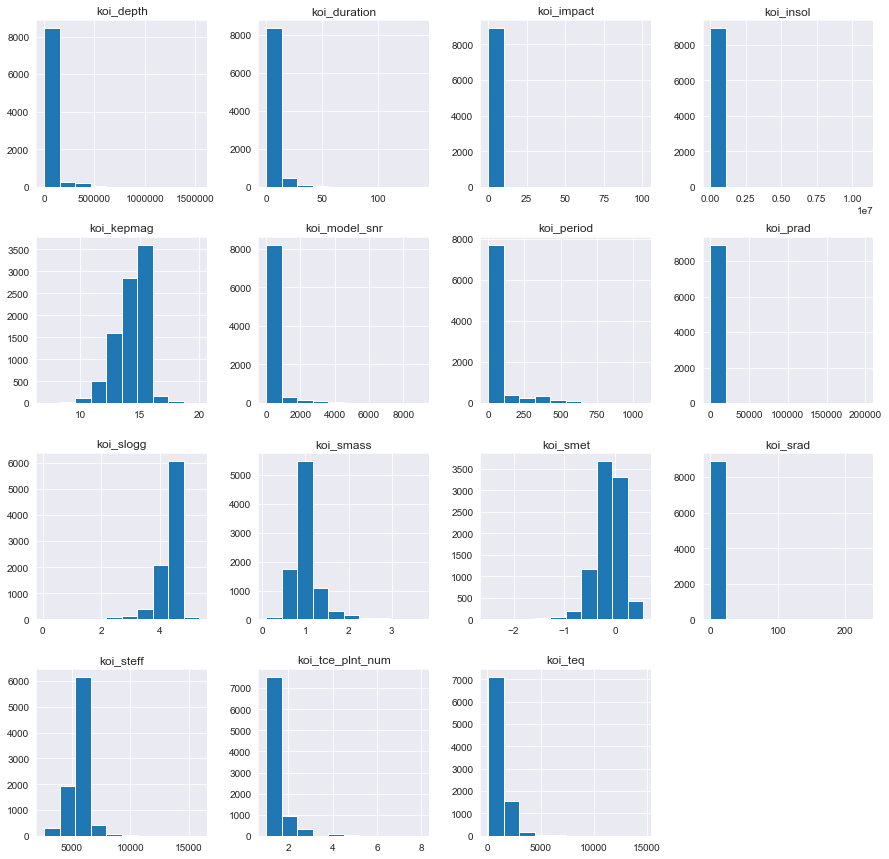

In [10]:
# examine the distributions for each variable
df.hist(figsize=(15,15));

**It looks like there are probably some outliers or other peculiar values in the data. Let's explore these, then get rid of outliers.**

In [11]:
continuous_data = ['koi_period','koi_impact','koi_duration','koi_depth', 'koi_prad',
                   'koi_teq','koi_insol','koi_model_snr','koi_steff','koi_srad']
categorical_data = ['koi_tce_plnt_num']

In [12]:
new_df = df.copy()

# removing outliers and peculiar data
indexNames = new_df[
#                     (new_df['koi_depth'] >= 4000) |
#                     (new_df['koi_duration'] >= 30) |
                    (new_df['koi_impact'] >= 1.5) |
                    (new_df['koi_insol'] >= 4500) |
                    (new_df['koi_model_snr'] >= 3000) |
#                     (new_df['koi_period'] >= 600) |
#                     (new_df['koi_prad'] >= 50) |
                    (new_df['koi_smet'] < -1.25) |
#                     (new_df['koi_srad'] > 4) |
                    (new_df['koi_steff'] >= 10000) |
                    (new_df['koi_teq'] >= 10000)].index
new_df.drop(indexNames, inplace=True)

print(len(new_df))

7775


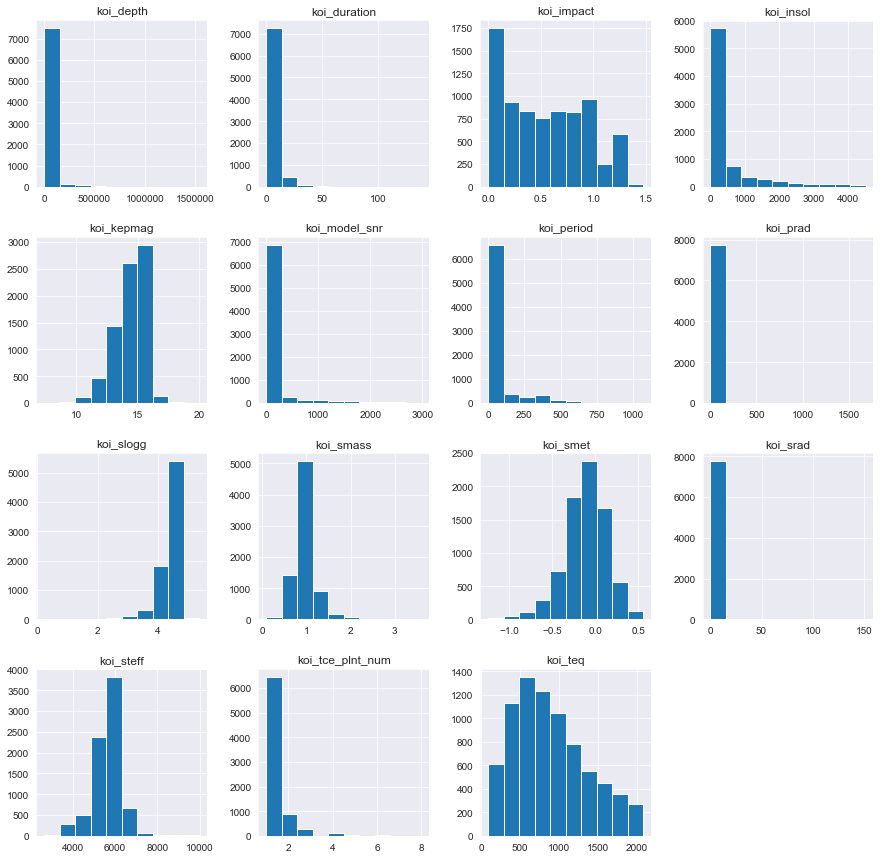

In [13]:
new_df.hist(figsize=(15,15));

**Though our elimination of NaNs and outliers reduced our dataset by over 15%, we still have over 7,500 observations, which should be more than enough to build a model.**

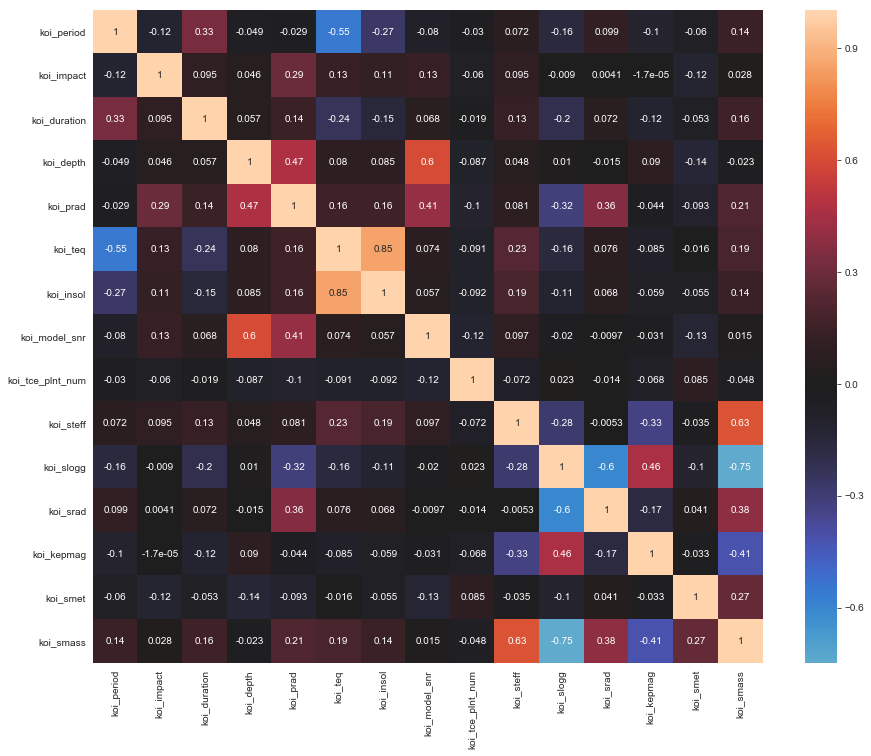

In [14]:
# look for multicollinearity
corr = new_df.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr, center=0, annot=True);

It seems there are a few instances of high multicollinearity in your dataset. Looking back to the Kepler API information website, it seems that `koi_teq` and `koi_insol` are two measures of the same thing (surface temperature), so we can safely remove one of those.

In [15]:
new_df.drop('koi_teq', axis=1, inplace=True)

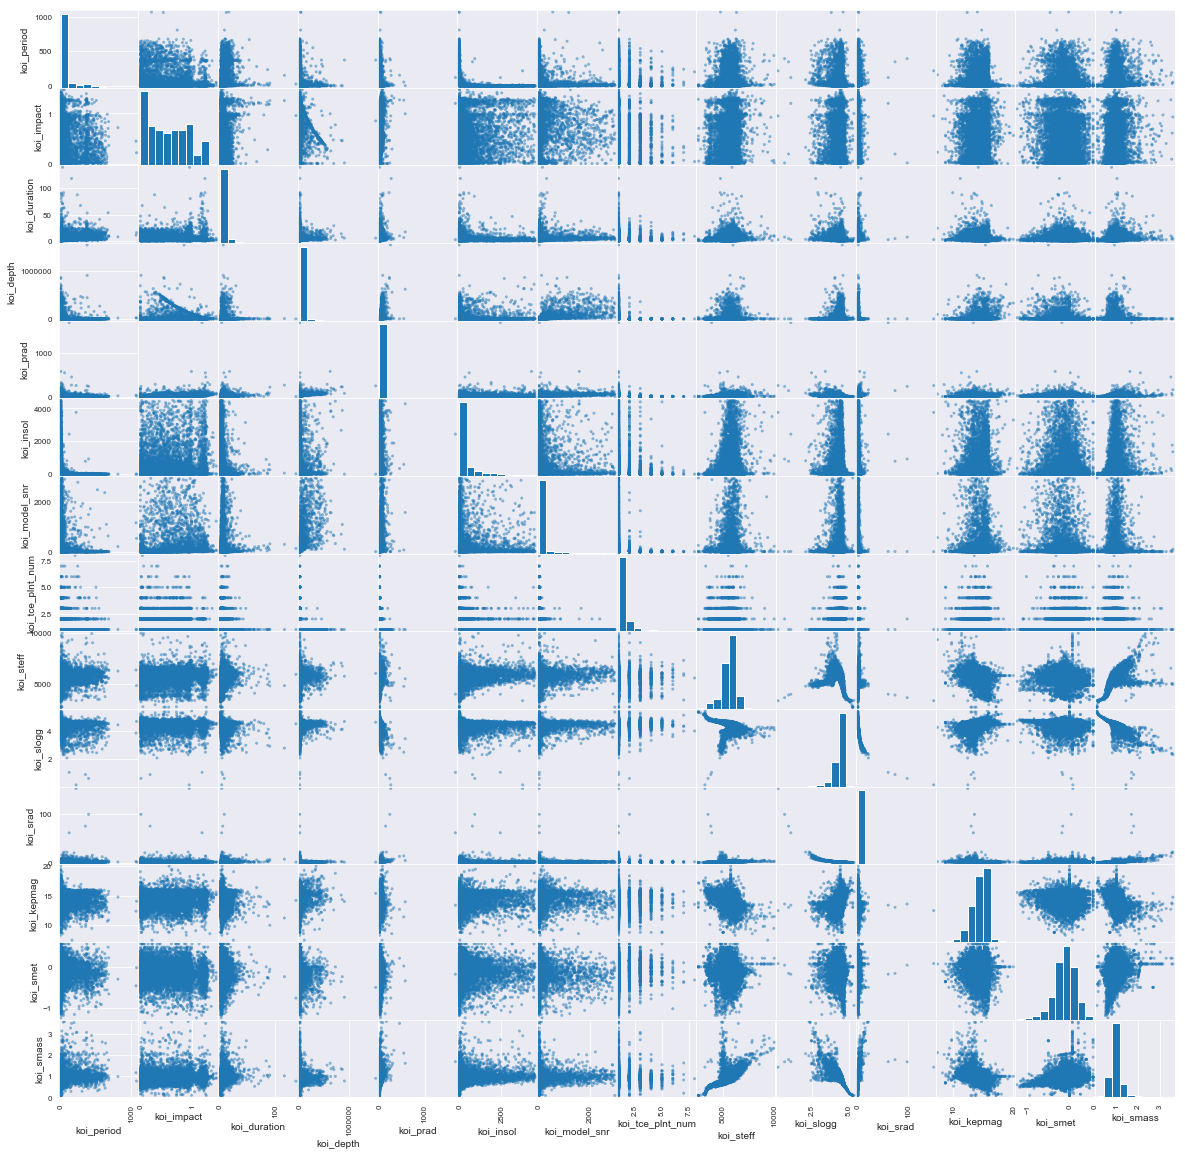

In [16]:
pd.plotting.scatter_matrix(new_df, figsize=(20,20));

The other multicollinear variables will be kept for the moment, but may be dropped later. Although they are very correlated, each one sounds like it could be an impactful measure in its own right. There are other instances of less severe multicollinearity (correlation score < |.6| ), but we will have to address these and the other multicollinear features we kept through weighting and feature engineering.

#### One-hot encoding categorical features

We actually only have one categorical variable remaining: `koi_tce_plnt_num`

In [17]:
new_df = pd.get_dummies(new_df, columns=['koi_tce_plnt_num'])

### Scaling the data & Encoding labels

First, let's log-transform some of the continuous data.

In [18]:
# Handling left skewed features
ks_max = 1 + new_df.koi_slogg.max()
new_df.koi_slogg = new_df.koi_slogg.map(lambda x: ks_max-x)

# log transforming non-linear data
non_normal = ['koi_depth', 'koi_duration', 'koi_period','koi_prad',
              'koi_srad','koi_insol','koi_model_snr', 'koi_slogg']
for feat in non_normal:
    new_df[feat] = new_df[feat].map(lambda x: np.log(x))

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [19]:
# due to wonky math, we need to address '-inf' value
new_df = new_df[new_df.koi_model_snr >= 0]

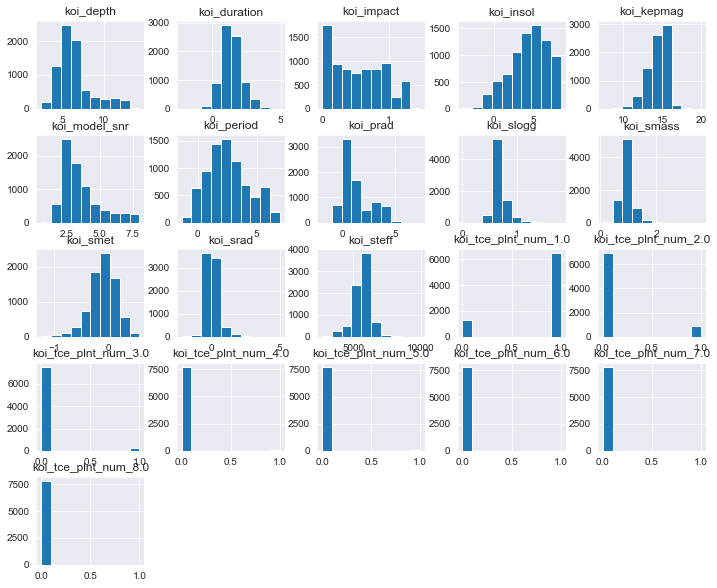

In [20]:
new_df.hist(figsize=(12,10));

**It looks like we still have a few outliers for some features, let's try to prune these out.**

In [21]:
# removing more outliers
indexNames = new_df[(new_df['koi_model_snr'] >= 500) |
                    (new_df['koi_slogg'] > 1.5) |
                    (new_df['koi_smass'] > 2) |
                    (new_df['koi_smet'] < -1.25) |
                    (new_df['koi_srad'] > 3) |
                    (new_df['koi_steff'] >= 9000)].index
new_df.drop(indexNames, inplace=True)

print(len(new_df))

7677


In [22]:
target = new_df.koi_pdisposition
variables = new_df.drop('koi_pdisposition', axis=1)

In [23]:
# encoding labels
le = LabelEncoder()
labels = pd.DataFrame(le.fit_transform(target), columns=['koi_pdisposition'])
labels.koi_pdisposition.value_counts()

0    4409
1    3268
Name: koi_pdisposition, dtype: int64

In [24]:
# scaling features
scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(variables), columns=variables.columns)

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


# Exploring the Data

In [25]:
features.describe()

,koi_period,koi_impact,koi_duration,koi_depth,koi_prad,koi_insol,koi_model_snr,koi_steff,koi_slogg,koi_srad,...,koi_smet,koi_smass,koi_tce_plnt_num_1.0,koi_tce_plnt_num_2.0,koi_tce_plnt_num_3.0,koi_tce_plnt_num_4.0,koi_tce_plnt_num_5.0,koi_tce_plnt_num_6.0,koi_tce_plnt_num_7.0,koi_tce_plnt_num_8.0
count,7.677000e+03,7.677000e+03,7.677000e+03,7.677000e+03,7.677000e+03,7.677000e+03,7.677000e+03,7.677000e+03,7.677000e+03,7677.000000,...,7.677000e+03,7.677000e+03,7.677000e+03,7677.000000,7.677000e+03,7677.000000,7.677000e+03,7.677000e+03,7.677000e+03,7.677000e+03
mean,-7.404379e-17,3.331971e-17,-1.480876e-16,1.184701e-16,5.923503e-17,2.221314e-17,-6.663941e-17,4.146452e-16,-4.664759e-16,0.000000,...,2.961752e-17,3.702190e-16,-9.625693e-17,0.000000,-7.404379e-18,0.000000,5.553284e-18,-2.036204e-17,9.255474e-18,-9.255474e-19
std,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065,...,1.000065e+00,1.000065e+00,1.000065e+00,1.000065,1.000065e+00,1.000065,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00
min,-2.235092e+00,-1.385603e+00,-4.904430e+00,-1.848321e+00,-2.362136e+00,-3.501979e+00,-2.004555e+00,-4.459965e+00,-5.094975e+00,-5.198445,...,-4.428850e+00,-3.800889e+00,-2.190511e+00,-0.361432,-1.963548e-01,-0.113712,-6.863982e-02,-4.118546e-02,-2.283218e-02,-1.141386e-02
25%,-7.195249e-01,-9.307801e-01,-6.542098e-01,-6.510531e-01,-6.915475e-01,-6.444248e-01,-7.262309e-01,-4.864028e-01,-6.058750e-01,-0.538975,...,-5.917000e-01,-5.809399e-01,4.565145e-01,-0.361432,-1.963548e-01,-0.113712,-6.863982e-02,-4.118546e-02,-2.283218e-02,-1.141386e-02
50%,-1.138988e-01,-5.849942e-02,-9.414652e-02,-2.404885e-01,-3.314433e-01,1.044673e-01,-3.117042e-01,1.625268e-01,-2.228086e-01,-0.143244,...,3.477348e-02,-2.228756e-02,4.565145e-01,-0.361432,-1.963548e-01,-0.113712,-6.863982e-02,-4.118546e-02,-2.283218e-02,-1.141386e-02
75%,6.161040e-01,8.537232e-01,5.670948e-01,2.570590e-01,4.989012e-01,7.639216e-01,3.985682e-01,6.575243e-01,3.766771e-01,0.351751,...,7.004016e-01,4.659834e-01,4.565145e-01,-0.361432,-1.963548e-01,-0.113712,-6.863982e-02,-4.118546e-02,-2.283218e-02,-1.141386e-02
max,2.509043e+00,2.415325e+00,4.734332e+00,3.565201e+00,3.726909e+00,1.699577e+00,2.990115e+00,4.395661e+00,5.478345e+00,6.393882,...,2.618977e+00,4.583296e+00,4.565145e-01,2.766770,5.092823e+00,8.794131,1.456880e+01,2.428041e+01,4.379783e+01,8.761278e+01


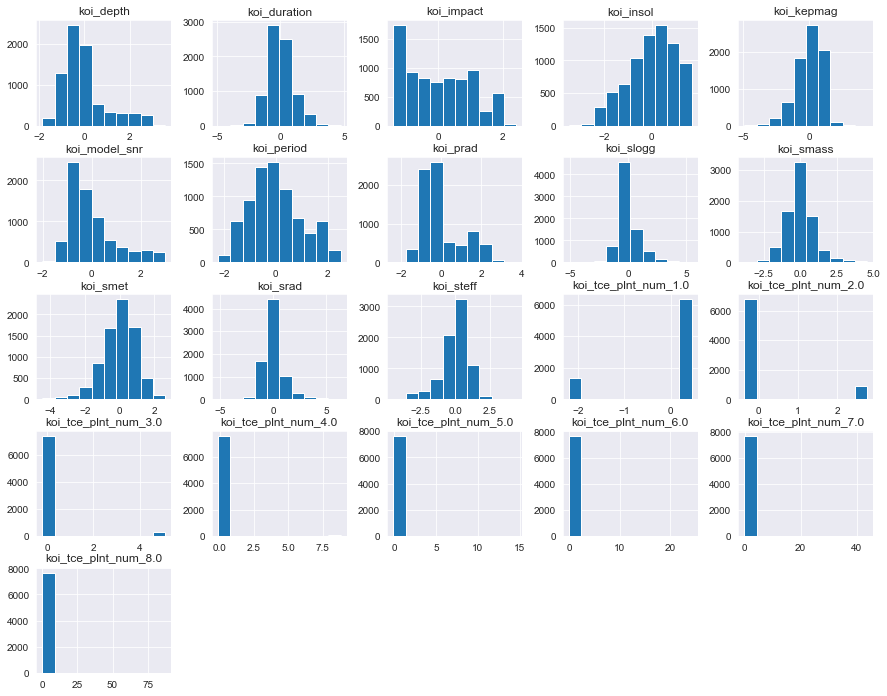

In [26]:
features.hist(figsize=(15,12));

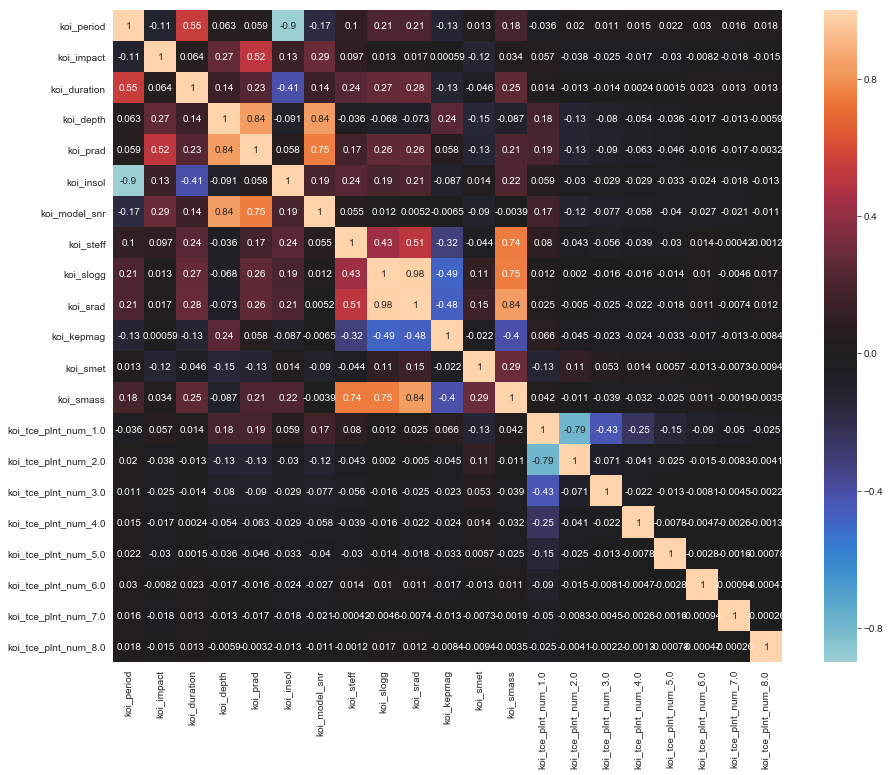

In [27]:
# look at correlation heatmap
corr = features.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr, center=0, annot=True);

### Handling multicollinearity

Let's engineer a few features to try to reduce some of the extreme multicollinearity seen in the heatmap above.

In [28]:
# creating a separate dataset for use with PCA later on
features_for_PCA = features.copy()
labels_PCA = labels.copy()

#### Building features

In [29]:
features_orig = features.copy()   #just in case
features['target'] = labels.koi_pdisposition.values

In [30]:
def feature_builder(var_1, var_2, target, dataset):
    """
    Parameters :
    ------------
    var_1 : column name of first correlated variable
    var_2 : column name of second correlated variable
    target : column name of target variable
    dataset : DataFrame that holds the data and will receive updates
    """
    weights = np.linspace(0, 1, 10000)
    max_corr = -1
    best_weights = None
    corrs = []

    for index, weight in enumerate(weights):
        w1 = weight       # get the first weight value
        w2 = 1 - weight   # get the second weight value
        vals = w1*dataset[var_1] + w2*dataset[var_2] # create a linear combination of the columns
        corr_coeff = np.abs(np.corrcoef(vals, dataset[target]))[0][1] # get the corrcoeff with the target

        # if the corr_coeff is larger than the max, store the weights and change the max
        if corr_coeff > max_corr:
            best_weights = [w1, w2]
            max_corr = corr_coeff

        # store the correlation coefficients to a list
        corrs.append(corr_coeff)  
    
    # output the desired weights
    print('weight for [',var_1,'] : weight for [',var_2,']\n  ', best_weights)
    feat_label = str(var_1+'_'+var_2+'_feat')
    print('feature name:', feat_label)
    
    # add feature to dataset & remove input columns
    dataset[feat_label] = w1*dataset[var_1] + w2*dataset[var_2]
    dataset.drop([var_1, var_2], axis=1, inplace=True)
    pass

In [31]:
features = features_orig.copy()
features['target'] = labels.koi_pdisposition.values

In [32]:
# Dropping highly collinear features (originally done
# one at a time, re-checking heatmap after each drop)
features.drop(['koi_insol','koi_srad','koi_prad',
               'koi_model_snr', 'koi_steff'], axis=1, inplace=True)

In [33]:
feature_builder('koi_smass','koi_slogg', 'target', features)

weight for [ koi_smass ] : weight for [ koi_slogg ]
   [0.6277627762776278, 0.3722372237223722]
feature name: koi_smass_koi_slogg_feat


In [34]:
feature_builder('koi_tce_plnt_num_1.0','koi_tce_plnt_num_2.0', 'target', features)

weight for [ koi_tce_plnt_num_1.0 ] : weight for [ koi_tce_plnt_num_2.0 ]
   [0.9101910191019102, 0.08980898089808975]
feature name: koi_tce_plnt_num_1.0_koi_tce_plnt_num_2.0_feat


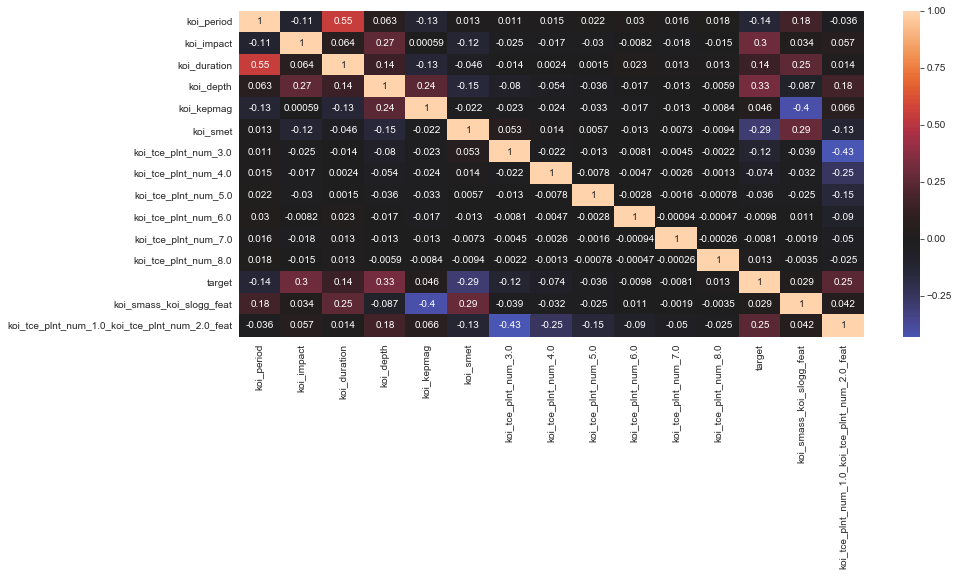

In [35]:
# look at correlation heatmap
corr = features.corr()
plt.figure(figsize=(14,6))
sns.heatmap(corr, center=0, annot=True);

In [36]:
features.drop(['target'], axis=1, inplace=True)

In [37]:
features.columns

Index(['koi_period', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_kepmag',
       'koi_smet', 'koi_tce_plnt_num_3.0', 'koi_tce_plnt_num_4.0',
       'koi_tce_plnt_num_5.0', 'koi_tce_plnt_num_6.0', 'koi_tce_plnt_num_7.0',
       'koi_tce_plnt_num_8.0', 'koi_smass_koi_slogg_feat',
       'koi_tce_plnt_num_1.0_koi_tce_plnt_num_2.0_feat'],
      dtype='object')

In [38]:
features.columns = ['koi_period', 'koi_impact', 'koi_duration', 'koi_depth',
                    'koi_kepmag', 'koi_smet', 'koi_tce_plnt_num_3.0', 
                    'koi_tce_plnt_num_4.0', 'koi_tce_plnt_num_5.0', 
                    'koi_tce_plnt_num_6.0', 'koi_tce_plnt_num_7.0',
                    'koi_tce_plnt_num_8.0', 'smass_slogg_feat',
                    'tce_plnt_num_1.0_2.0_feat']

In [39]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7677 entries, 0 to 7676
Data columns (total 14 columns):
koi_period                   7677 non-null float64
koi_impact                   7677 non-null float64
koi_duration                 7677 non-null float64
koi_depth                    7677 non-null float64
koi_kepmag                   7677 non-null float64
koi_smet                     7677 non-null float64
koi_tce_plnt_num_3.0         7677 non-null float64
koi_tce_plnt_num_4.0         7677 non-null float64
koi_tce_plnt_num_5.0         7677 non-null float64
koi_tce_plnt_num_6.0         7677 non-null float64
koi_tce_plnt_num_7.0         7677 non-null float64
koi_tce_plnt_num_8.0         7677 non-null float64
smass_slogg_feat             7677 non-null float64
tce_plnt_num_1.0_2.0_feat    7677 non-null float64
dtypes: float64(14)
memory usage: 839.8 KB


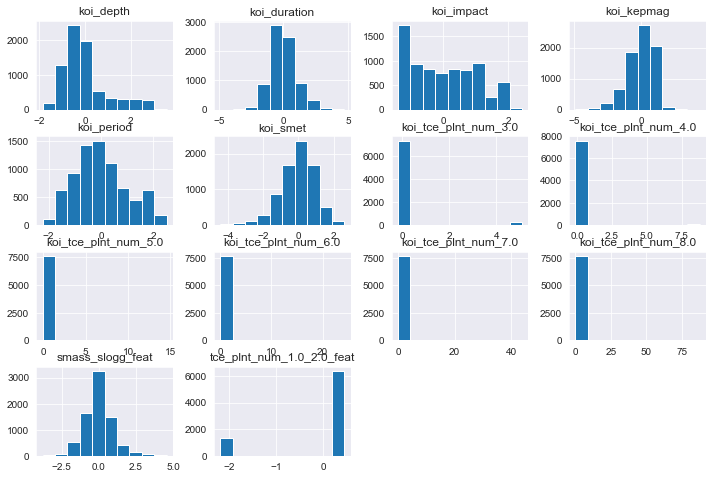

In [40]:
features.hist(figsize=(12,8));

### Recursive Feature Elimination

In [41]:
xgb0 = XGBClassifier(learning_rate=0.1, n_estimators=1000,
                     objective='binary:logistic',
                     nthread=4,seed=42)
rfecv = RFECV(estimator=xgb0, step=1, cv=StratifiedKFold(),
              scoring='accuracy', n_jobs=4)
rfecv.fit(features, labels.values.flatten())

print(f"Optimal number of features : {rfecv.n_features_}")

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\sklearn\model_selection\_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimal number of features : 7


**Well, it appears that we do not gain much information by using more than 7 features. In the next section we will run a model and visualize feature importances to see which 7 features are the most important.**

In [42]:
# define a function to generate a confusion matrix
def confu_matrix(y_pred, x_tst, y_tst):
    import warnings
    warnings.filterwarnings('ignore')
    y_pred = np.array(y_pred).flatten()
    y_tst = np.array(y_tst).flatten()
    cm = confusion_matrix(y_tst.flatten(), y_pred.flatten())
    sns.heatmap(cm, annot=True, fmt='0g', 
                annot_kws={'size':14, 'ha':'center', 'va':'top'})
    sns.heatmap(cm/np.sum(cm), annot=True, fmt='0.01%', 
                annot_kws={'size':14, 'ha':'center', 'va':'bottom'})
    plt.title('Confusion Matrix', fontsize=14)
    plt.show();

Number of mislabeled points out of a total points : 2696
Accuracy: 64.88000000000001 %


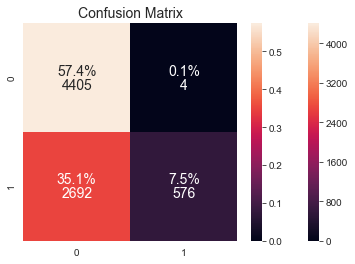

In [43]:
# very simple test model with Guassian Naive Bayes
gnb = GaussianNB()
y_pred = gnb.fit(features, labels.values.flatten()).predict(features)
wrong = (labels.koi_pdisposition.values != y_pred).sum()
print(f"Number of mislabeled points out of a total points : {wrong}")
print("Accuracy:",round(accuracy_score(labels, y_pred),4)*100,"%")
confu_matrix(gnb.predict(features), features, labels)

# Modeling the data

### Train, test, split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42)

In [45]:
classifiers = [KNeighborsClassifier, SVC, DecisionTreeClassifier,
               RandomForestClassifier, AdaBoostClassifier,
               XGBClassifier, LogisticRegression, GaussianNB]

In [46]:
classy_scores = []
for classifier in classifiers:
    clf = classifier()
    clf.fit(X_train, y_train.values.flatten())
    score = clf.score(X_test, y_test.values.flatten())
    classy_scores.append((str(classifier), score))
ranked_classifiers = sorted(classy_scores, key=lambda x: x[1], reverse=True)

ranked_classifiers

[("<class 'sklearn.svm.classes.SVC'>", 0.8296875),
 ("<class 'xgboost.sklearn.XGBClassifier'>", 0.8197916666666667),
 ("<class 'sklearn.ensemble.forest.RandomForestClassifier'>",
  0.8166666666666667),
 ("<class 'sklearn.neighbors.classification.KNeighborsClassifier'>",
  0.8083333333333333),
 ("<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>", 0.803125),
 ("<class 'sklearn.tree.tree.DecisionTreeClassifier'>", 0.7677083333333333),
 ("<class 'sklearn.linear_model.logistic.LogisticRegression'>", 0.7546875),
 ("<class 'sklearn.naive_bayes.GaussianNB'>", 0.6494791666666667)]

### Trying XGBoost without PCA

In [47]:
# create a function to automate model fitting and visualizing feature importance
def modelfit(alg, x_tr, y_tr, x_tst, y_tst, n_estims=1000, early_stopping_rounds=10):
    """
    Inputs:
    alg: instantiated model
    X_train / X_test / y_train / y_test
    n_estims: number of trees to create
    early_stopping_rounds: number of rounds of no scoring metric improvement
                           after which the cross validation will stop
    """
    #Fit the algorithm on the data
    eval_set = [(x_tst, y_tst)]
    alg.fit(x_tr, y_tr, eval_metric='error@.8', eval_set=eval_set, early_stopping_rounds=10)
    
    #Predict training set:
    dtrain_predictions = alg.predict(x_tr)
    dtrain_predprob = alg.predict_proba(x_tr)[:,1]
    #Predict testing set:
    dtest_predictions = alg.predict(x_tst)
    dtest_predprob = alg.predict_proba(x_tst)[:,1]
    
    #Print model report:
    print("Model Report")
    print(f"Train accuracy: {round(accuracy_score(y_tr, dtrain_predictions), 4)*100}%")
    print(f"Test accuracy: {round(accuracy_score(y_tst, dtest_predictions), 4)*100}%")
    print(f"AUC Score (Train): {roc_auc_score(y_tr, dtrain_predprob)}")
    print(f"AUC Score (Test): {roc_auc_score(y_tst, dtest_predprob)}")
    
    # plotting feature importances
    feat_imp = pd.Series(alg.get_booster()\
                         .get_score(importance_type='weight'))\
                         .sort_values(ascending=False)
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    feat_imp.plot(kind='bar')
    plt.title('Feature Importances', fontsize=14)
    plt.ylabel('Feature Importance Score', fontsize=14)
    plt.xticks(fontsize=14, rotation=45, horizontalalignment='right')
    
    # plotting confusion matrix
    plt.subplot(122)
    confu_matrix(alg.predict(x_tst), x_tst, y_tst);

[0]	validation_0-error@0.8:0.413021
Will train until validation_0-error@0.8 hasn't improved in 10 rounds.
[1]	validation_0-error@0.8:0.413021
[2]	validation_0-error@0.8:0.413021
[3]	validation_0-error@0.8:0.413021
[4]	validation_0-error@0.8:0.413021
[5]	validation_0-error@0.8:0.413021
[6]	validation_0-error@0.8:0.413021
[7]	validation_0-error@0.8:0.413021
[8]	validation_0-error@0.8:0.413021
[9]	validation_0-error@0.8:0.334896
[10]	validation_0-error@0.8:0.334375
[11]	validation_0-error@0.8:0.328646
[12]	validation_0-error@0.8:0.320833
[13]	validation_0-error@0.8:0.309896
[14]	validation_0-error@0.8:0.304688
[15]	validation_0-error@0.8:0.3
[16]	validation_0-error@0.8:0.298438
[17]	validation_0-error@0.8:0.29375
[18]	validation_0-error@0.8:0.290104
[19]	validation_0-error@0.8:0.289063
[20]	validation_0-error@0.8:0.285937
[21]	validation_0-error@0.8:0.282292
[22]	validation_0-error@0.8:0.279687
[23]	validation_0-error@0.8:0.277604
[24]	validation_0-error@0.8:0.275521
[25]	validation_0-err

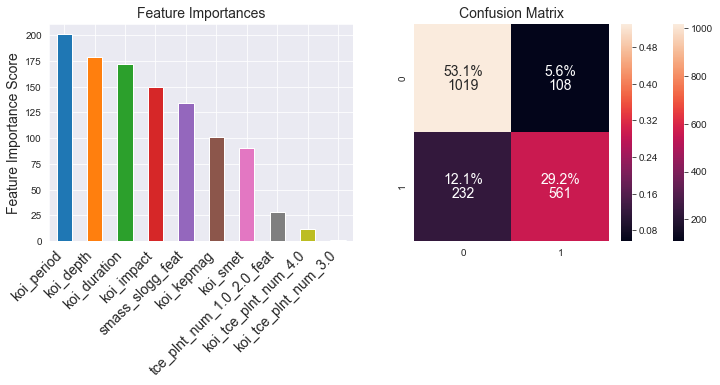

In [48]:
xgb1 = XGBClassifier(learning_rate=0.1,
                     n_estimators=1000,
                     objective='binary:logistic',
                     nthread=4,
                     seed=42)
modelfit(xgb1, X_train, y_train.values.flatten(), X_test, y_test.values.flatten(), 1000, 20)

**Now we know which features are the most important, so let's drop everything but the top 7 features.**

In [49]:
features = features[['koi_period', 'koi_impact', 'koi_duration',
                     'koi_depth', 'koi_kepmag', 'koi_smet',
                     'smass_slogg_feat']]

X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42)

[0]	validation_0-error@0.8:0.413021
Will train until validation_0-error@0.8 hasn't improved in 10 rounds.
[1]	validation_0-error@0.8:0.413021
[2]	validation_0-error@0.8:0.413021
[3]	validation_0-error@0.8:0.413021
[4]	validation_0-error@0.8:0.413021
[5]	validation_0-error@0.8:0.413021
[6]	validation_0-error@0.8:0.413021
[7]	validation_0-error@0.8:0.413021
[8]	validation_0-error@0.8:0.413021
[9]	validation_0-error@0.8:0.382813
[10]	validation_0-error@0.8:0.328125
[11]	validation_0-error@0.8:0.320313
[12]	validation_0-error@0.8:0.310417
[13]	validation_0-error@0.8:0.306771
[14]	validation_0-error@0.8:0.301042
[15]	validation_0-error@0.8:0.297396
[16]	validation_0-error@0.8:0.291667
[17]	validation_0-error@0.8:0.290625
[18]	validation_0-error@0.8:0.284896
[19]	validation_0-error@0.8:0.283333
[20]	validation_0-error@0.8:0.282292
[21]	validation_0-error@0.8:0.282292
[22]	validation_0-error@0.8:0.280729
[23]	validation_0-error@0.8:0.276563
[24]	validation_0-error@0.8:0.276042
[25]	validation

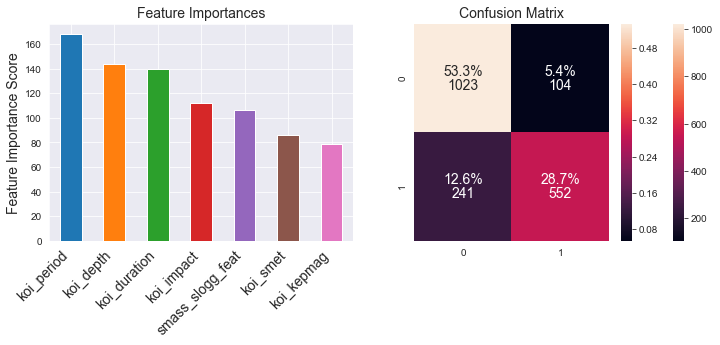

In [50]:
xgb1 = XGBClassifier(learning_rate=0.1,
                     n_estimators=1000,
                     objective='binary:logistic',
                     nthread=4,
                     seed=42)
modelfit(xgb1, X_train, y_train.values.flatten(), X_test, y_test.values.flatten(), 1000, 20)

**The test accuracy dropped very slightly but, more importantly, we have reduced overfitting by a larger margin.**

## Trying to build a function to chain estimators together

I'm trying to build a function(s) that will fit a model, take the observations for which the model had a low-confidence prediction, and then fit a different model on that subset of data.

In [51]:
def low_conf_preds(estimator, x_tr, y_tr, threshold=.8):
    """
    Identifies model predictions made with low confidence
    ---------------Inputs-------------------------------
    estimator :   model instance which will generate predictions
    x_tr :        X_train
    y_tr :        y_train
    threshold :   value in range .51-.99 (default=0.8)
    ----------------Returns 6 datasets:-----------------
    low-conf. X
    low-conf. y
    low-conf. model predictions
    high-conf. X
    high-conf. y
    high-conf. model predictions
    """
    # fitting and making predictions
    # estimator.fit(x_tr, y_tr)
    pred_probs = estimator.predict_proba(x_tr)
    preds = estimator.predict(x_tr)
    
    #combining all data into one dataframe
    x_tr['no'] = pred_probs[:,0]
    x_tr['yes'] = pred_probs[:,1]
    x_tr['pred'] = preds
    x_tr['target'] = y_tr.values.flatten()
    X_low_conf = x_tr.loc[(x_tr.no <= threshold) & (x_tr.yes <= threshold)]
    X_high_conf = x_tr.loc[(x_tr.no > threshold) | (x_tr.yes > threshold)]
    y_low_conf = X_low_conf['target']
    y_high_conf = X_high_conf['target']
    y_low_preds = X_low_conf['pred']
    y_high_preds = X_high_conf['pred']
    
    # removing unwanted columns from dataframes
    X_low_conf.drop(['no','yes','target','pred'], axis=1, inplace=True)
    X_high_conf.drop(['no','yes','target','pred'], axis=1, inplace=True)
    x_tr.drop(['no','yes','target','pred'], axis=1, inplace=True)
    
    return X_low_conf, y_low_conf, y_low_preds, X_high_conf, y_high_conf, y_high_preds

[0]	validation_0-error@0.8:0.413021
Will train until validation_0-error@0.8 hasn't improved in 10 rounds.
[1]	validation_0-error@0.8:0.413021
[2]	validation_0-error@0.8:0.413021
[3]	validation_0-error@0.8:0.413021
[4]	validation_0-error@0.8:0.413021
[5]	validation_0-error@0.8:0.413021
[6]	validation_0-error@0.8:0.413021
[7]	validation_0-error@0.8:0.413021
[8]	validation_0-error@0.8:0.413021
[9]	validation_0-error@0.8:0.382813
[10]	validation_0-error@0.8:0.328125
[11]	validation_0-error@0.8:0.320313
[12]	validation_0-error@0.8:0.310417
[13]	validation_0-error@0.8:0.306771
[14]	validation_0-error@0.8:0.301042
[15]	validation_0-error@0.8:0.297396
[16]	validation_0-error@0.8:0.291667
[17]	validation_0-error@0.8:0.290625
[18]	validation_0-error@0.8:0.284896
[19]	validation_0-error@0.8:0.283333
[20]	validation_0-error@0.8:0.282292
[21]	validation_0-error@0.8:0.282292
[22]	validation_0-error@0.8:0.280729
[23]	validation_0-error@0.8:0.276563
[24]	validation_0-error@0.8:0.276042
[25]	validation

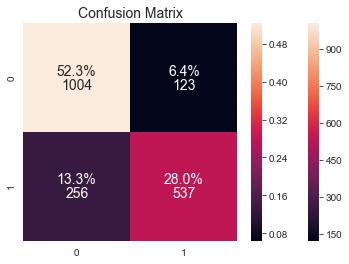

In [52]:
# Fitting models to training data
model1 = XGBClassifier(learning_rate=0.1, n_estimators=1000, objective='binary:logistic',
                     nthread=4, scale_pos_weight=1, seed=42)
model2 = SVC(probability=True, kernel='rbf', C=1, class_weight='balanced', gamma='auto', random_state=42)
model3 = RandomForestClassifier()

eval_set=[(X_test, y_test)]
model1.fit(X_train, y_train, eval_metric='error@.8', eval_set=eval_set, early_stopping_rounds=10)
x_low1, y_low1, y_low1_preds, x_high1, y_high1, y_high1_preds = low_conf_preds(model1, X_train, y_train, .8)

model2.fit(x_low1, y_low1)
x_low2, y_low2, y_low2_preds, x_high2, y_high2, y_high2_preds = low_conf_preds(model2, x_low1, y_low1, .8)

model3.fit(x_low2, y_low2)
x_low3, y_low3, y_low3_preds, x_high3, y_high3, y_high3_preds = low_conf_preds(model3, x_low2, y_low2, .8)


x_trnnn = x_high1.append(x_high2).append(x_low3).append(x_high3)
y_trnnn = y_high1.append(y_high2).append(y_low3).append(y_high3)
y_hat = y_high1_preds.append(y_high2_preds).append(y_low3_preds).append(y_high3_preds)

# Running models on testing data
x_low1t, y_low1t, y_low1_predst, x_high1t, y_high1t, y_high1_predst = low_conf_preds(model1, X_test, y_test, .8)
x_low2t, y_low2t, y_low2_predst, x_high2t, y_high2t, y_high2_predst = low_conf_preds(model2, x_low1t, y_low1t, .8)
x_low3t, y_low3t, y_low3_predst, x_high3t, y_high3t, y_high3_predst = low_conf_preds(model3, x_low2t, y_low2t, .8)

x_tsttt = x_high1t.append(x_high2t).append(x_low3t).append(x_high3t)
y_tsttt = y_high1t.append(y_high2t).append(y_low3t).append(y_high3t)
y_hat_tst = y_high1_predst.append(y_high2_predst).append(y_low3_predst).append(y_high3_predst)

print(f"Train accuracy : {accuracy_score(y_train.sort_index().values, y_hat.sort_index())}")
print(f"Test accuracy : {accuracy_score(y_test.sort_index().values, y_hat_tst.sort_index())}")
# confu_matrix(y_hat, x_trnnn, y_trnnn) #train confusion matrix
confu_matrix(y_hat_tst, x_tsttt, y_tsttt) #test confusion matrix

### Using GridSearchCV to tune hyperparameters

In [53]:
# defining functions to get the best parameters
def convert_params(best_params):
    params = {}
    for key, val in best_params.items():
        params[key] = [val]
    return params


def get_best_params(cv_results):
    """
    input:     model.cv_results_
    returns:   dictionary of parameters with the highest harmonic 
    mean balancing mean_test_score and (1 - test_train_diff)
    This reduces overfitting while maximizing test score.
    """
    dfp = pd.DataFrame(cv_results)
    dfp['test_train_diff'] = np.abs(dfp['mean_train_score'] - dfp['mean_test_score'])
    dfp['harmonic'] = 2 / ((1 / dfp['mean_test_score']) + (1 / (1-dfp['test_train_diff'])))
    dfp.sort_values(by='harmonic', ascending=False, inplace=True)
    dfp.reset_index(drop=True, inplace=True)
    return convert_params(dfp.iloc[0].params)

In [54]:
def gridsearch_params(estimator, params_test, old_params=None, 
                      update_params=True, scoring='accuracy',
                      eval_metric='error@.75', xgb=False):
    """
    Inputs an instantiated estimator and a dictionary of parameters
    for tuning (optionally an old dictionary of established parameters)
    Returns a dictionary of the new best parameters.
    Requires X_train, X_test, y_train, y_test to exist as global variables.
    """
    import warnings
    warnings.filterwarnings('ignore')
    if update_params:
        old_params.update(params_test)
        params_test = old_params
    gsearch1 = GridSearchCV(estimator=estimator, refit=True,
                            param_grid=params_test, scoring=scoring,
                            n_jobs=4, iid=False, cv=5)
    if xgb:
        gsearch1.fit(X_train, y_train.values.flatten(), early_stopping_rounds=10, 
                     eval_set=[(X_test, y_test.values.flatten())], 
                     eval_metric=eval_metric, verbose=False)
    else:
        gsearch1.fit(X_train, y_train.values.flatten())
    best_params = get_best_params(gsearch1.cv_results_)
    gsearch1a = GridSearchCV(estimator=estimator, refit=True,
                             param_grid=best_params, scoring=scoring,
                             n_jobs=4, iid=False, cv=5)
    if xgb:
        gsearch1a.fit(X_train, y_train.values.flatten(), early_stopping_rounds=10,
                      eval_set=[(X_test, y_test.values.flatten())],
                      eval_metric=eval_metric, verbose=False)
    else:
        gsearch1a.fit(X_train, y_train.values.flatten())
    confu_matrix(gsearch1a.predict(X_test), X_test, y_test)
    tr_acc = round(accuracy_score(y_train.values.flatten(),
                                  gsearch1a.predict(X_train)), 4)*100
    tst_acc = round(accuracy_score(y_test.values.flatten(),
                                   gsearch1a.predict(X_test)), 4)*100
    print(f"Train accuracy: {tr_acc}%\nTest accuracy: {tst_acc}%\n{best_params}")
    return best_params, gsearch1a

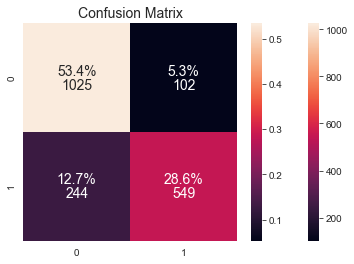

Train accuracy: 84.0%
Test accuracy: 81.98%
{'max_depth': [3], 'min_child_weight': [4]}


In [68]:
param_test1 = {'max_depth':range(3,8),
               'min_child_weight':range(1,6)
              }
xgb1a = XGBClassifier(learning_rate=0.1, n_estimators=1000,
                      objective='binary:logistic', nthread=4, seed=42)
best_params, xgb_gs1 = gridsearch_params(xgb1a, param_test1,
                                         update_params=False, xgb=True)

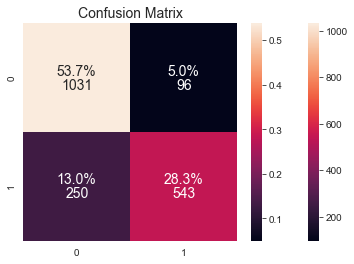

Train accuracy: 83.57%
Test accuracy: 81.98%
{'colsample_bytree': [0.8500000000000001], 'gamma': [0.05], 'max_depth': [3], 'min_child_weight': [4], 'subsample': [0.95]}


In [69]:
param_test2 = {'gamma': np.linspace(0.0, 0.2, 5),
               'subsample':np.linspace(.8, 1.0, 5),
               'colsample_bytree':np.linspace(.8, 1.0, 5)
              }
xgb1a = XGBClassifier(learning_rate=0.1, n_estimators=1000,
                      objective='binary:logistic', nthread=4, seed=42)
best_params, xgb_gs2 = gridsearch_params(xgb1a, param_test2, best_params,
                                         update_params=True, xgb=True)

In [65]:
# be sure to input values seen in printout above!
mod_xgb_grid = XGBClassifier(learning_rate=0.1, n_estimators=1000,
                             colsample_bytree=0.85, gamma=0.05, max_depth=3,
                             min_child_weight=4, subsample=0.95,
                             objective='binary:logistic', nthread=4, seed=42)

[0]	validation_0-error@0.8:0.413021
[1]	validation_0-error@0.8:0.413021
[2]	validation_0-error@0.8:0.413021
[3]	validation_0-error@0.8:0.413021
[4]	validation_0-error@0.8:0.413021
[5]	validation_0-error@0.8:0.413021
[6]	validation_0-error@0.8:0.413021
[7]	validation_0-error@0.8:0.413021
[8]	validation_0-error@0.8:0.407292
[9]	validation_0-error@0.8:0.398958
[10]	validation_0-error@0.8:0.394271
[11]	validation_0-error@0.8:0.390104
[12]	validation_0-error@0.8:0.374479
[13]	validation_0-error@0.8:0.358854
[14]	validation_0-error@0.8:0.333333
[15]	validation_0-error@0.8:0.348437
[16]	validation_0-error@0.8:0.323438
[17]	validation_0-error@0.8:0.317708
[18]	validation_0-error@0.8:0.309896
[19]	validation_0-error@0.8:0.301562
[20]	validation_0-error@0.8:0.297917
[21]	validation_0-error@0.8:0.29375
[22]	validation_0-error@0.8:0.290104
[23]	validation_0-error@0.8:0.289583
[24]	validation_0-error@0.8:0.286458
[25]	validation_0-error@0.8:0.283854
[26]	validation_0-error@0.8:0.279167
[27]	validat

[220]	validation_0-error@0.8:0.210938
[221]	validation_0-error@0.8:0.210938
[222]	validation_0-error@0.8:0.210938
[223]	validation_0-error@0.8:0.210938
[224]	validation_0-error@0.8:0.210938
[225]	validation_0-error@0.8:0.210417
[226]	validation_0-error@0.8:0.210417
[227]	validation_0-error@0.8:0.210938
[228]	validation_0-error@0.8:0.210417
[229]	validation_0-error@0.8:0.210417
[230]	validation_0-error@0.8:0.210417
[231]	validation_0-error@0.8:0.209896
[232]	validation_0-error@0.8:0.210417
[233]	validation_0-error@0.8:0.208854
[234]	validation_0-error@0.8:0.208333
[235]	validation_0-error@0.8:0.207813
[236]	validation_0-error@0.8:0.207813
[237]	validation_0-error@0.8:0.208854
[238]	validation_0-error@0.8:0.208854
[239]	validation_0-error@0.8:0.207813
[240]	validation_0-error@0.8:0.207813
[241]	validation_0-error@0.8:0.207813
[242]	validation_0-error@0.8:0.208333
[243]	validation_0-error@0.8:0.208333
[244]	validation_0-error@0.8:0.208333
[245]	validation_0-error@0.8:0.208333
[246]	valida

[437]	validation_0-error@0.8:0.202604
[438]	validation_0-error@0.8:0.203646
[439]	validation_0-error@0.8:0.204167
[440]	validation_0-error@0.8:0.204167
[441]	validation_0-error@0.8:0.204167
[442]	validation_0-error@0.8:0.203646
[443]	validation_0-error@0.8:0.203646
[444]	validation_0-error@0.8:0.204167
[445]	validation_0-error@0.8:0.204167
[446]	validation_0-error@0.8:0.204167
[447]	validation_0-error@0.8:0.203646
[448]	validation_0-error@0.8:0.203646
[449]	validation_0-error@0.8:0.203646
[450]	validation_0-error@0.8:0.203125
[451]	validation_0-error@0.8:0.203125
[452]	validation_0-error@0.8:0.203125
[453]	validation_0-error@0.8:0.203125
[454]	validation_0-error@0.8:0.203125
[455]	validation_0-error@0.8:0.203646
[456]	validation_0-error@0.8:0.203125
[457]	validation_0-error@0.8:0.203125
[458]	validation_0-error@0.8:0.203125
[459]	validation_0-error@0.8:0.203646
[460]	validation_0-error@0.8:0.203646
[461]	validation_0-error@0.8:0.203646
[462]	validation_0-error@0.8:0.203125
[463]	valida

[660]	validation_0-error@0.8:0.201042
[661]	validation_0-error@0.8:0.201042
[662]	validation_0-error@0.8:0.201042
[663]	validation_0-error@0.8:0.201042
[664]	validation_0-error@0.8:0.201042
[665]	validation_0-error@0.8:0.201042
[666]	validation_0-error@0.8:0.201562
[667]	validation_0-error@0.8:0.202083
[668]	validation_0-error@0.8:0.202083
[669]	validation_0-error@0.8:0.201562
[670]	validation_0-error@0.8:0.201042
[671]	validation_0-error@0.8:0.201042
[672]	validation_0-error@0.8:0.200521
[673]	validation_0-error@0.8:0.200521
[674]	validation_0-error@0.8:0.200521
[675]	validation_0-error@0.8:0.201042
[676]	validation_0-error@0.8:0.201042
[677]	validation_0-error@0.8:0.201562
[678]	validation_0-error@0.8:0.201562
[679]	validation_0-error@0.8:0.201562
[680]	validation_0-error@0.8:0.200521
[681]	validation_0-error@0.8:0.200521
[682]	validation_0-error@0.8:0.200521
[683]	validation_0-error@0.8:0.201042
[684]	validation_0-error@0.8:0.201042
[685]	validation_0-error@0.8:0.201042
[686]	valida

[879]	validation_0-error@0.8:0.196354
[880]	validation_0-error@0.8:0.196354
[881]	validation_0-error@0.8:0.196354
[882]	validation_0-error@0.8:0.196354
[883]	validation_0-error@0.8:0.196354
[884]	validation_0-error@0.8:0.195833
[885]	validation_0-error@0.8:0.195833
[886]	validation_0-error@0.8:0.196875
[887]	validation_0-error@0.8:0.196875
[888]	validation_0-error@0.8:0.196875
[889]	validation_0-error@0.8:0.196875
[890]	validation_0-error@0.8:0.196875
[891]	validation_0-error@0.8:0.197396
[892]	validation_0-error@0.8:0.197396
[893]	validation_0-error@0.8:0.196875
[894]	validation_0-error@0.8:0.196875
[895]	validation_0-error@0.8:0.196354
[896]	validation_0-error@0.8:0.197396
[897]	validation_0-error@0.8:0.196875
[898]	validation_0-error@0.8:0.197396
[899]	validation_0-error@0.8:0.197396
[900]	validation_0-error@0.8:0.197396
[901]	validation_0-error@0.8:0.197396
[902]	validation_0-error@0.8:0.197396
[903]	validation_0-error@0.8:0.197396
[904]	validation_0-error@0.8:0.197396
[905]	valida

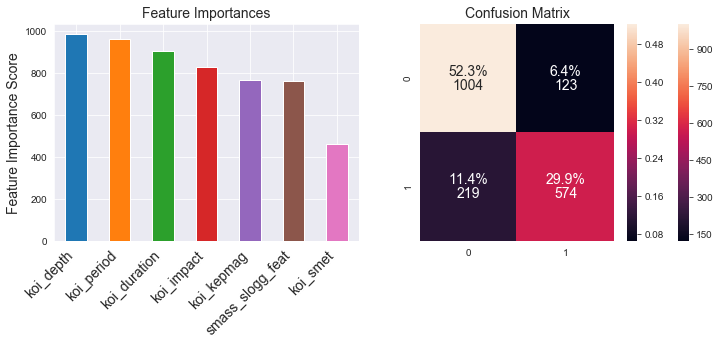

In [66]:
# Looking at feature importances
mod_xgb_grid.fit(X_train, y_train, eval_metric='error@.8',
                 eval_set=[(X_test, y_test.values.flatten())])

feat_imp = pd.Series(mod_xgb_grid.get_booster()\
                     .get_score(importance_type='weight'))\
                     .sort_values(ascending=False)

print(f"\nTrain accuracy: {round(accuracy_score(y_train.values.flatten(), mod_xgb_grid.predict(X_train)), 4)*100}%")
print(f"Test accuracy: {round(accuracy_score(y_test.values.flatten(), mod_xgb_grid.predict(X_test)), 4)*100}%")

plt.figure(figsize=(12,4))
plt.subplot(121)
feat_imp.plot(kind='bar')
plt.title('Feature Importances', fontsize=14)
plt.ylabel('Feature Importance Score', fontsize=14)
plt.xticks(fontsize=14, rotation=45, horizontalalignment='right')

# plotting confusion matrix
plt.subplot(122)
confu_matrix(mod_xgb_grid.predict(X_test), X_test, y_test);

### Chaining through two other models

In [70]:
# Fitting model 1 to training data
model1 = xgb_gs2
# model1.fit(X_train, y_train, eval_metric='error@.8',
#                  eval_set=[(X_test, y_test.values.flatten())])
x_low1, y_low1, y_low1_preds, x_high1, y_high1, y_high1_preds = low_conf_preds(model1, X_train, y_train, .8)

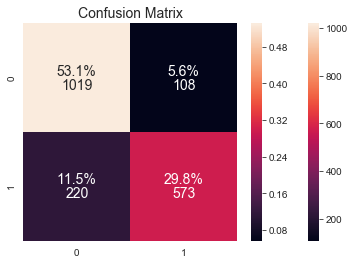

Train accuracy: 85.24000000000001%
Test accuracy: 82.92%
{}


In [71]:
# Testing SVC vanilla just to see how it performs
svc = SVC(random_state=42, gamma='auto')
svc_params = {}
best_params, model2 = gridsearch_params(svc, svc_params, update_params=False)

**Regrettably, when using SVC with the rbf kernel, there is no way to determine feature importances since rbf essentially transforms the data into a higher dimensional space.**

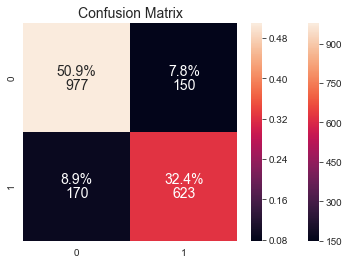

Train accuracy: 84.59%
Test accuracy: 83.33%
{'C': [0.5], 'class_weight': ['balanced'], 'gamma': ['auto'], 'kernel': ['rbf'], 'probability': [True]}


In [83]:
# Tuning SVC (model 2) parameters for each possible kernel
# beginning with default 'rbf' kernel
svc = SVC(random_state=42)
svc_params1a = {'kernel':['rbf'],
                'C': np.linspace(.1, 1.9, 10),
                'class_weight': [None,'balanced'],
                'gamma': ['auto','scale']
               }
best_params_a, model2a = gridsearch_params(svc, svc_params1a, update_params=False)

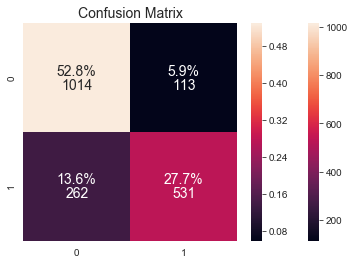

Train accuracy: 81.17%
Test accuracy: 80.47%
{'C': [50], 'class_weight': ['balanced'], 'gamma': ['auto'], 'kernel': ['poly']}


In [89]:
# Tuning SVC 'poly' kernel
svc = SVC(random_state=42)
svc_params1b = {'kernel':['poly'],
                'C': [.1, 1, 10, 25, 50, 75, 100],
                'class_weight': [None,'balanced'],
                'gamma': ['auto','scale']
               }
best_params_b, model2b = gridsearch_params(svc, svc_params1b, update_params=False)

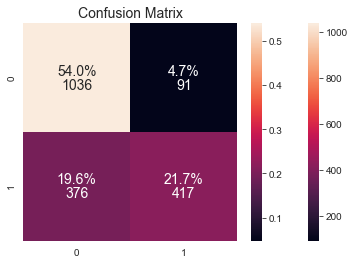

Train accuracy: 76.79%
Test accuracy: 75.68%
{'C': [0.3], 'class_weight': [None], 'kernel': ['linear']}


In [90]:
# Tuning SVC 'linear' kernel
svc = SVC(random_state=42)
svc_params1c = {'kernel':['linear'],
                'C': np.linspace(.1, 1.9, 10),
                'class_weight': [None,'balanced']
               }
best_params_c, model2c = gridsearch_params(svc, svc_params1c, update_params=False)

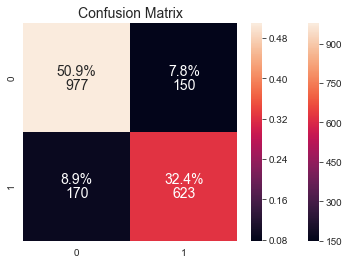

Train accuracy: 84.59%
Test accuracy: 83.33%
{'C': [0.5], 'class_weight': ['balanced'], 'gamma': ['auto'], 'kernel': ['rbf'], 'probability': [True]}


In [91]:
# now pick the best kernel between the three versions above
svc = SVC(random_state=42, probability=True)
svc_params2 = [best_params_a, best_params_b, best_params_c]
best_params, model2 = gridsearch_params(svc, svc_params2, update_params=False)

In [92]:
# fitting model 2 to low-confidence values from model 1
model2.fit(x_low1, y_low1)
x_low2, y_low2, y_low2_preds, x_high2, y_high2, y_high2_preds = low_conf_preds(model2, x_low1, y_low1, .8)

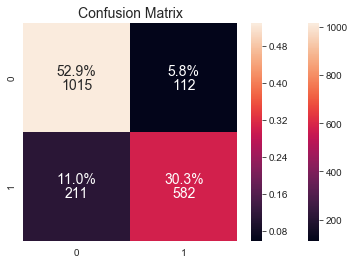

Train accuracy: 99.98%
Test accuracy: 83.17999999999999%
{'n_estimators': [90]}


In [93]:
# Testing RandomForestClassifier vanilla to see how it performs
rfc = RandomForestClassifier(random_state=42)
rfc_params = {'n_estimators': [i*10 for i in range(1,11)]}
best_params, model3 = gridsearch_params(rfc, rfc_params, update_params=False)

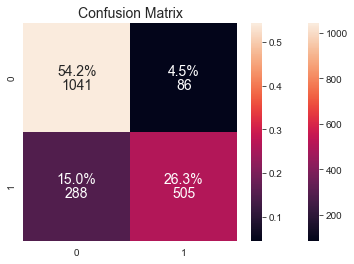

Train accuracy: 81.38%
Test accuracy: 80.52%
{'criterion': ['gini'], 'max_depth': [4], 'min_impurity_decrease': [0.001], 'min_samples_split': [4], 'n_estimators': [100]}


In [94]:
# Tuning RFC (model 3) parameters and fitting it to low-confidence data from model 2
rfc = RandomForestClassifier(random_state=42)
rfc_params = {'n_estimators': [i*10 for i in range(1,11)],
              'criterion': ['gini','entropy'],
              'max_depth': range(2,5),
              'min_samples_split': range(2,6),
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }
best_params, model3 = gridsearch_params(rfc, rfc_params, update_params=False)

In [95]:
#  Fitting model 3 to low-confidence observations from model 2
model3.fit(x_low2, y_low2)
x_low3, y_low3, y_low3_preds, x_high3, y_high3, y_high3_preds = low_conf_preds(model3, x_low2, y_low2, .8)

Train accuracy : 0.8346360951884663
Test accuracy : 0.8005208333333333


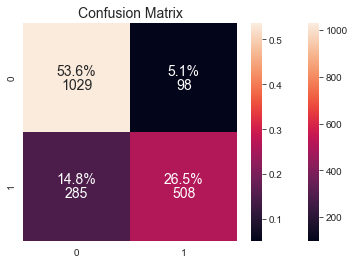

In [96]:
# re-building the training dataset
x_trnnn = x_high1.append(x_high2).append(x_low3).append(x_high3)
y_trnnn = y_high1.append(y_high2).append(y_low3).append(y_high3)
y_hat = y_high1_preds.append(y_high2_preds).append(y_low3_preds).append(y_high3_preds)

# Running models on testing data
x_low1t, y_low1t, y_low1_predst, x_high1t, y_high1t, y_high1_predst = low_conf_preds(model1, X_test, y_test, .8)
x_low2t, y_low2t, y_low2_predst, x_high2t, y_high2t, y_high2_predst = low_conf_preds(model2, x_low1t, y_low1t, .8)
x_low3t, y_low3t, y_low3_predst, x_high3t, y_high3t, y_high3_predst = low_conf_preds(model3, x_low2t, y_low2t, .8)

#re-building the testing dataset
x_tsttt = x_high1t.append(x_high2t).append(x_low3t).append(x_high3t)
y_tsttt = y_high1t.append(y_high2t).append(y_low3t).append(y_high3t)
y_hat_tst = y_high1_predst.append(y_high2_predst).append(y_low3_predst).append(y_high3_predst)

#output
print(f"Train accuracy : {accuracy_score(y_trnnn.sort_index().values, y_hat.sort_index())}")
print(f"Test accuracy : {accuracy_score(y_tsttt.sort_index().values, y_hat_tst.sort_index())}")
confu_matrix(y_hat_tst, x_tsttt, y_tsttt)

**Apparently this was *not* an improvement over previous solo methods.**

## Principal Component Analysis

First, we need to determine how many engineered features are required in order to explain at least 95% of the variance in the dataset. We can do this using Principal Component Analysis.

Number of features which explain 95% of variance:   14


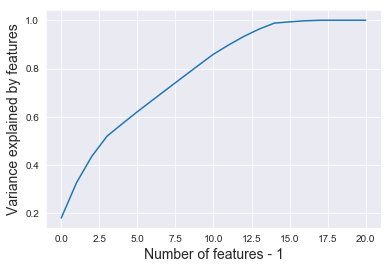

In [97]:
# perfrom Principal Component Analysis to determine how many features
# will explain 95% of model variance
pca = PCA()
features_pca = pca.fit_transform(features_for_PCA)
variance = pca.explained_variance_ratio_.cumsum()
plt.plot(range(features_pca.shape[1]), variance)
plt.xlabel("Number of features - 1", fontsize=14)
plt.ylabel("Variance explained by features", fontsize=14);

n_features = len(variance[variance <= .95]) + 1
print(f'Number of features which explain 95% of variance:   {n_features}')

### Train test split again for PCA

In [98]:
# train, test, split PCA data for future models
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels_PCA, random_state=42)

### Compare classification methods

In [99]:
classifiers = [KNeighborsClassifier, SVC, DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, XGBClassifier]

In [100]:
classy_scores = []
for classifier in classifiers:
    clf = classifier()
    clf.fit(X_train, y_train.values.flatten())
    score = clf.score(X_test, y_test.values.flatten())
    classy_scores.append((str(classifier), score))
ranked_classifiers = sorted(classy_scores, key=lambda x: x[1], reverse=True)

ranked_classifiers

[("<class 'sklearn.svm.classes.SVC'>", 0.8359375),
 ("<class 'sklearn.neighbors.classification.KNeighborsClassifier'>",
  0.8197916666666667),
 ("<class 'xgboost.sklearn.XGBClassifier'>", 0.815625),
 ("<class 'sklearn.ensemble.forest.RandomForestClassifier'>",
  0.8057291666666667),
 ("<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>",
  0.7973958333333333),
 ("<class 'sklearn.tree.tree.DecisionTreeClassifier'>", 0.7838541666666666)]

### Begin tuning parameters for XGBoost

Many thanks to this site: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ for providing a walkthrough to tuning XGBoost parameters.

[0]	validation_0-error@0.8:0.413021
Will train until validation_0-error@0.8 hasn't improved in 10 rounds.
[1]	validation_0-error@0.8:0.413021
[2]	validation_0-error@0.8:0.413021
[3]	validation_0-error@0.8:0.413021
[4]	validation_0-error@0.8:0.413021
[5]	validation_0-error@0.8:0.413021
[6]	validation_0-error@0.8:0.413021
[7]	validation_0-error@0.8:0.413021
[8]	validation_0-error@0.8:0.413021
[9]	validation_0-error@0.8:0.340625
[10]	validation_0-error@0.8:0.327604
[11]	validation_0-error@0.8:0.315104
[12]	validation_0-error@0.8:0.305208
[13]	validation_0-error@0.8:0.297396
[14]	validation_0-error@0.8:0.288021
[15]	validation_0-error@0.8:0.290625
[16]	validation_0-error@0.8:0.283333
[17]	validation_0-error@0.8:0.278646
[18]	validation_0-error@0.8:0.279167
[19]	validation_0-error@0.8:0.275521
[20]	validation_0-error@0.8:0.273438
[21]	validation_0-error@0.8:0.268229
[22]	validation_0-error@0.8:0.267188
[23]	validation_0-error@0.8:0.266146
[24]	validation_0-error@0.8:0.264062
[25]	validation

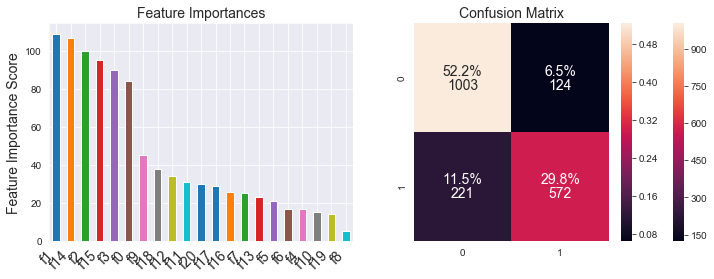

In [101]:
xgb_pca = XGBClassifier(learning_rate=0.1,
                     n_estimators=1000,
                     objective='binary:logistic',
                     nthread=4,
                     seed=42)
modelfit(xgb_pca, X_train, y_train.values.flatten(), X_test, y_test.values.flatten(), 1000, 20)

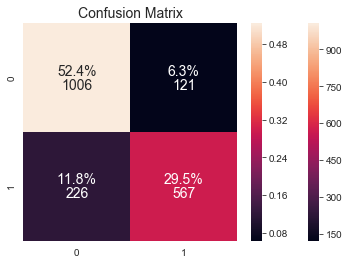

Train accuracy: 86.57000000000001%
Test accuracy: 81.93%
{'max_depth': [3], 'min_child_weight': [2]}


In [104]:
# building a model with default parameters
xgb_params = {}
xgb_pca = XGBClassifier(learning_rate=0.1, n_estimators=100, nthread=4,
                        random_state=42, objective='binary:logistic')
best_params, clf_xgb = gridsearch_params(xgb_pca, param_test1, update_params=False, xgb=True)

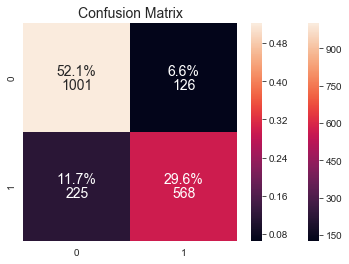

Train accuracy: 86.82%
Test accuracy: 81.72%
{'max_depth': [3], 'min_child_weight': [2]}


In [105]:
# Tuning max_depth, min_child_weight
param_test1 = {'max_depth':range(3,8), 
              'min_child_weight':range(1,6)
              }
xgb_pca = XGBClassifier(learning_rate=0.1, n_estimators=1000,
                        objective='binary:logistic', nthread=4, seed=42)
best_params, clf_xgb = gridsearch_params(xgb_pca, param_test1, update_params=False, xgb=True)

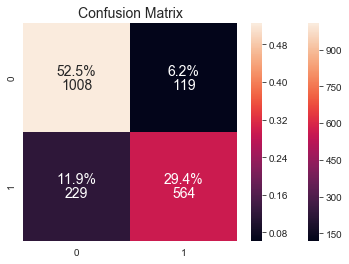

Train accuracy: 86.68%
Test accuracy: 81.88%
{'colsample_bytree': [1.0], 'gamma': [0.2], 'max_depth': [3], 'min_child_weight': [2], 'subsample': [0.9]}


In [106]:
# Tuning gamma, subsample, and colsample_bytree
param_test2 = {'gamma': np.linspace(0.0, 0.2, 5),
               'subsample':np.linspace(.8, 1.0, 5),
               'colsample_bytree':np.linspace(.8, 1.0, 5)
              }
best_params, clf_xgb = gridsearch_params(xgb_pca, param_test2, best_params,
                                         update_params=True, xgb=True)

### Begin tuning parameters for SVM

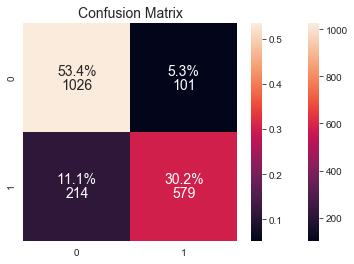

Train accuracy: 85.6%
Test accuracy: 83.59%
{}


In [107]:
# building a model with default parameters
svc_pca = SVC(random_state=42, gamma='auto')
svc_params = {}
best_params, clf_svc = gridsearch_params(svc_pca, svc_params, update_params=False)

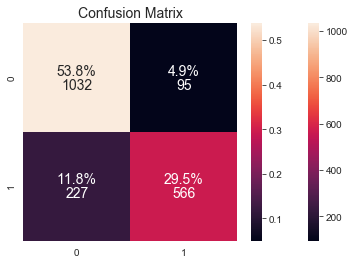

Train accuracy: 84.94%
Test accuracy: 83.23%
{'C': [0.7], 'class_weight': [None], 'gamma': ['scale'], 'probability': [True]}


In [108]:
# tuning hyperparameters
svc_pca = SVC(random_state=42)
svc_params = {'probability':[True],
              'C': np.linspace(.1, 1.9, 10),
              'class_weight': [None,'balanced'],
              'gamma': ['auto','scale']
             }
best_params, clf_svc = gridsearch_params(svc_pca, svc_params, update_params=False)

**Though the test score went down slightly, at least overfitting has been reduced by more.**

## Use Stacking

Here's some articles on it:
    - https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/
    - http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/

In [109]:
def Stacking(model, train, test, y, n_fold, xgb=False, eval_metric='error@.8'):
    train = pd.DataFrame(train)
    test = pd.DataFrame(test)
    folds = StratifiedKFold(n_splits=n_fold, random_state=42)
    test_pred = np.empty((0,1), float)
    train_pred = np.empty((0,1), float)
    for train_indices, val_indices in folds.split(train, y.values):
        if xgb:
            x_tr, x_val = train.iloc[train_indices], train.iloc[val_indices]
            y_tr, y_val = y.iloc[train_indices], y.iloc[val_indices]
            model.fit(x_tr, y_tr, eval_metric='error@.8',
                      eval_set=[(x_val, y_val)])
            train_pred = np.append(train_pred, model.predict(x_val))
        else:
            x_tr, x_val = train.iloc[train_indices], train.iloc[val_indices]
            y_tr, y_val = y.iloc[train_indices], y.iloc[val_indices]
            model.fit(x_tr, y_tr)
            train_pred = np.append(train_pred, model.predict(x_val))
    test_pred = np.append(test_pred, model.predict(test))
    return test_pred, train_pred

In [110]:
#base model 1 (XGBoostClassifier)
model1 = clf_xgb

test_pred1, train_pred1 = Stacking(model=model1, n_fold=10, train=X_train,
                                   test=X_test, y=y_train.koi_pdisposition,
                                   xgb=True)

train_pred1 = pd.DataFrame(train_pred1)
test_pred1 = pd.DataFrame(test_pred1)

[0]	validation_0-error@0.8:0.429809
[1]	validation_0-error@0.8:0.429809
[2]	validation_0-error@0.8:0.429809
[3]	validation_0-error@0.8:0.429809
[4]	validation_0-error@0.8:0.429809
[5]	validation_0-error@0.8:0.429809
[6]	validation_0-error@0.8:0.429809
[7]	validation_0-error@0.8:0.429809
[8]	validation_0-error@0.8:0.429809
[9]	validation_0-error@0.8:0.336222
[10]	validation_0-error@0.8:0.331023
[11]	validation_0-error@0.8:0.317158
[12]	validation_0-error@0.8:0.303293
[13]	validation_0-error@0.8:0.303293
[14]	validation_0-error@0.8:0.294627
[15]	validation_0-error@0.8:0.291161
[16]	validation_0-error@0.8:0.285962
[17]	validation_0-error@0.8:0.282496
[18]	validation_0-error@0.8:0.282496
[19]	validation_0-error@0.8:0.280763
[20]	validation_0-error@0.8:0.279029
[21]	validation_0-error@0.8:0.277296
[22]	validation_0-error@0.8:0.279029
[23]	validation_0-error@0.8:0.277296
[24]	validation_0-error@0.8:0.275563
[25]	validation_0-error@0.8:0.272097
[26]	validation_0-error@0.8:0.27383
[27]	validat

[219]	validation_0-error@0.8:0.232236
[220]	validation_0-error@0.8:0.228769
[221]	validation_0-error@0.8:0.230503
[222]	validation_0-error@0.8:0.230503
[223]	validation_0-error@0.8:0.228769
[224]	validation_0-error@0.8:0.228769
[225]	validation_0-error@0.8:0.230503
[226]	validation_0-error@0.8:0.228769
[227]	validation_0-error@0.8:0.230503
[228]	validation_0-error@0.8:0.230503
[229]	validation_0-error@0.8:0.230503
[230]	validation_0-error@0.8:0.228769
[231]	validation_0-error@0.8:0.228769
[232]	validation_0-error@0.8:0.228769
[233]	validation_0-error@0.8:0.228769
[234]	validation_0-error@0.8:0.228769
[235]	validation_0-error@0.8:0.228769
[236]	validation_0-error@0.8:0.228769
[237]	validation_0-error@0.8:0.228769
[238]	validation_0-error@0.8:0.228769
[239]	validation_0-error@0.8:0.228769
[240]	validation_0-error@0.8:0.228769
[241]	validation_0-error@0.8:0.230503
[242]	validation_0-error@0.8:0.230503
[243]	validation_0-error@0.8:0.230503
[244]	validation_0-error@0.8:0.230503
[245]	valida

[436]	validation_0-error@0.8:0.218371
[437]	validation_0-error@0.8:0.218371
[438]	validation_0-error@0.8:0.218371
[439]	validation_0-error@0.8:0.218371
[440]	validation_0-error@0.8:0.218371
[441]	validation_0-error@0.8:0.216638
[442]	validation_0-error@0.8:0.216638
[443]	validation_0-error@0.8:0.216638
[444]	validation_0-error@0.8:0.214905
[445]	validation_0-error@0.8:0.216638
[446]	validation_0-error@0.8:0.218371
[447]	validation_0-error@0.8:0.216638
[448]	validation_0-error@0.8:0.218371
[449]	validation_0-error@0.8:0.218371
[450]	validation_0-error@0.8:0.218371
[451]	validation_0-error@0.8:0.216638
[452]	validation_0-error@0.8:0.218371
[453]	validation_0-error@0.8:0.216638
[454]	validation_0-error@0.8:0.213172
[455]	validation_0-error@0.8:0.214905
[456]	validation_0-error@0.8:0.214905
[457]	validation_0-error@0.8:0.214905
[458]	validation_0-error@0.8:0.214905
[459]	validation_0-error@0.8:0.214905
[460]	validation_0-error@0.8:0.214905
[461]	validation_0-error@0.8:0.216638
[462]	valida

[652]	validation_0-error@0.8:0.216638
[653]	validation_0-error@0.8:0.216638
[654]	validation_0-error@0.8:0.216638
[655]	validation_0-error@0.8:0.216638
[656]	validation_0-error@0.8:0.216638
[657]	validation_0-error@0.8:0.216638
[658]	validation_0-error@0.8:0.214905
[659]	validation_0-error@0.8:0.218371
[660]	validation_0-error@0.8:0.220104
[661]	validation_0-error@0.8:0.218371
[662]	validation_0-error@0.8:0.218371
[663]	validation_0-error@0.8:0.218371
[664]	validation_0-error@0.8:0.218371
[665]	validation_0-error@0.8:0.214905
[666]	validation_0-error@0.8:0.216638
[667]	validation_0-error@0.8:0.216638
[668]	validation_0-error@0.8:0.216638
[669]	validation_0-error@0.8:0.216638
[670]	validation_0-error@0.8:0.214905
[671]	validation_0-error@0.8:0.216638
[672]	validation_0-error@0.8:0.216638
[673]	validation_0-error@0.8:0.216638
[674]	validation_0-error@0.8:0.214905
[675]	validation_0-error@0.8:0.213172
[676]	validation_0-error@0.8:0.213172
[677]	validation_0-error@0.8:0.213172
[678]	valida

[868]	validation_0-error@0.8:0.214905
[869]	validation_0-error@0.8:0.216638
[870]	validation_0-error@0.8:0.214905
[871]	validation_0-error@0.8:0.214905
[872]	validation_0-error@0.8:0.214905
[873]	validation_0-error@0.8:0.214905
[874]	validation_0-error@0.8:0.214905
[875]	validation_0-error@0.8:0.213172
[876]	validation_0-error@0.8:0.213172
[877]	validation_0-error@0.8:0.213172
[878]	validation_0-error@0.8:0.213172
[879]	validation_0-error@0.8:0.213172
[880]	validation_0-error@0.8:0.213172
[881]	validation_0-error@0.8:0.214905
[882]	validation_0-error@0.8:0.214905
[883]	validation_0-error@0.8:0.213172
[884]	validation_0-error@0.8:0.213172
[885]	validation_0-error@0.8:0.213172
[886]	validation_0-error@0.8:0.213172
[887]	validation_0-error@0.8:0.209705
[888]	validation_0-error@0.8:0.209705
[889]	validation_0-error@0.8:0.209705
[890]	validation_0-error@0.8:0.209705
[891]	validation_0-error@0.8:0.209705
[892]	validation_0-error@0.8:0.209705
[893]	validation_0-error@0.8:0.209705
[894]	valida

[87]	validation_0-error@0.8:0.221837
[88]	validation_0-error@0.8:0.22357
[89]	validation_0-error@0.8:0.22357
[90]	validation_0-error@0.8:0.221837
[91]	validation_0-error@0.8:0.220104
[92]	validation_0-error@0.8:0.221837
[93]	validation_0-error@0.8:0.221837
[94]	validation_0-error@0.8:0.220104
[95]	validation_0-error@0.8:0.220104
[96]	validation_0-error@0.8:0.220104
[97]	validation_0-error@0.8:0.220104
[98]	validation_0-error@0.8:0.220104
[99]	validation_0-error@0.8:0.216638
[100]	validation_0-error@0.8:0.218371
[101]	validation_0-error@0.8:0.220104
[102]	validation_0-error@0.8:0.218371
[103]	validation_0-error@0.8:0.220104
[104]	validation_0-error@0.8:0.220104
[105]	validation_0-error@0.8:0.221837
[106]	validation_0-error@0.8:0.221837
[107]	validation_0-error@0.8:0.221837
[108]	validation_0-error@0.8:0.221837
[109]	validation_0-error@0.8:0.221837
[110]	validation_0-error@0.8:0.221837
[111]	validation_0-error@0.8:0.216638
[112]	validation_0-error@0.8:0.216638
[113]	validation_0-error@0.

[303]	validation_0-error@0.8:0.207972
[304]	validation_0-error@0.8:0.206239
[305]	validation_0-error@0.8:0.206239
[306]	validation_0-error@0.8:0.206239
[307]	validation_0-error@0.8:0.206239
[308]	validation_0-error@0.8:0.206239
[309]	validation_0-error@0.8:0.206239
[310]	validation_0-error@0.8:0.206239
[311]	validation_0-error@0.8:0.206239
[312]	validation_0-error@0.8:0.206239
[313]	validation_0-error@0.8:0.206239
[314]	validation_0-error@0.8:0.206239
[315]	validation_0-error@0.8:0.207972
[316]	validation_0-error@0.8:0.207972
[317]	validation_0-error@0.8:0.207972
[318]	validation_0-error@0.8:0.207972
[319]	validation_0-error@0.8:0.209705
[320]	validation_0-error@0.8:0.209705
[321]	validation_0-error@0.8:0.209705
[322]	validation_0-error@0.8:0.209705
[323]	validation_0-error@0.8:0.207972
[324]	validation_0-error@0.8:0.209705
[325]	validation_0-error@0.8:0.209705
[326]	validation_0-error@0.8:0.209705
[327]	validation_0-error@0.8:0.209705
[328]	validation_0-error@0.8:0.209705
[329]	valida

[520]	validation_0-error@0.8:0.204506
[521]	validation_0-error@0.8:0.204506
[522]	validation_0-error@0.8:0.204506
[523]	validation_0-error@0.8:0.204506
[524]	validation_0-error@0.8:0.204506
[525]	validation_0-error@0.8:0.204506
[526]	validation_0-error@0.8:0.204506
[527]	validation_0-error@0.8:0.204506
[528]	validation_0-error@0.8:0.202773
[529]	validation_0-error@0.8:0.202773
[530]	validation_0-error@0.8:0.202773
[531]	validation_0-error@0.8:0.202773
[532]	validation_0-error@0.8:0.202773
[533]	validation_0-error@0.8:0.202773
[534]	validation_0-error@0.8:0.20104
[535]	validation_0-error@0.8:0.20104
[536]	validation_0-error@0.8:0.20104
[537]	validation_0-error@0.8:0.20104
[538]	validation_0-error@0.8:0.202773
[539]	validation_0-error@0.8:0.202773
[540]	validation_0-error@0.8:0.202773
[541]	validation_0-error@0.8:0.202773
[542]	validation_0-error@0.8:0.202773
[543]	validation_0-error@0.8:0.202773
[544]	validation_0-error@0.8:0.202773
[545]	validation_0-error@0.8:0.202773
[546]	validation

[736]	validation_0-error@0.8:0.197574
[737]	validation_0-error@0.8:0.195841
[738]	validation_0-error@0.8:0.195841
[739]	validation_0-error@0.8:0.197574
[740]	validation_0-error@0.8:0.195841
[741]	validation_0-error@0.8:0.195841
[742]	validation_0-error@0.8:0.195841
[743]	validation_0-error@0.8:0.195841
[744]	validation_0-error@0.8:0.195841
[745]	validation_0-error@0.8:0.195841
[746]	validation_0-error@0.8:0.195841
[747]	validation_0-error@0.8:0.195841
[748]	validation_0-error@0.8:0.195841
[749]	validation_0-error@0.8:0.195841
[750]	validation_0-error@0.8:0.195841
[751]	validation_0-error@0.8:0.195841
[752]	validation_0-error@0.8:0.195841
[753]	validation_0-error@0.8:0.195841
[754]	validation_0-error@0.8:0.195841
[755]	validation_0-error@0.8:0.195841
[756]	validation_0-error@0.8:0.195841
[757]	validation_0-error@0.8:0.195841
[758]	validation_0-error@0.8:0.195841
[759]	validation_0-error@0.8:0.195841
[760]	validation_0-error@0.8:0.195841
[761]	validation_0-error@0.8:0.195841
[762]	valida

[952]	validation_0-error@0.8:0.194107
[953]	validation_0-error@0.8:0.194107
[954]	validation_0-error@0.8:0.194107
[955]	validation_0-error@0.8:0.194107
[956]	validation_0-error@0.8:0.194107
[957]	validation_0-error@0.8:0.194107
[958]	validation_0-error@0.8:0.194107
[959]	validation_0-error@0.8:0.192374
[960]	validation_0-error@0.8:0.194107
[961]	validation_0-error@0.8:0.194107
[962]	validation_0-error@0.8:0.194107
[963]	validation_0-error@0.8:0.194107
[964]	validation_0-error@0.8:0.194107
[965]	validation_0-error@0.8:0.194107
[966]	validation_0-error@0.8:0.194107
[967]	validation_0-error@0.8:0.194107
[968]	validation_0-error@0.8:0.194107
[969]	validation_0-error@0.8:0.192374
[970]	validation_0-error@0.8:0.192374
[971]	validation_0-error@0.8:0.192374
[972]	validation_0-error@0.8:0.192374
[973]	validation_0-error@0.8:0.192374
[974]	validation_0-error@0.8:0.192374
[975]	validation_0-error@0.8:0.192374
[976]	validation_0-error@0.8:0.194107
[977]	validation_0-error@0.8:0.194107
[978]	valida

[171]	validation_0-error@0.8:0.201389
[172]	validation_0-error@0.8:0.197917
[173]	validation_0-error@0.8:0.201389
[174]	validation_0-error@0.8:0.201389
[175]	validation_0-error@0.8:0.204861
[176]	validation_0-error@0.8:0.204861
[177]	validation_0-error@0.8:0.201389
[178]	validation_0-error@0.8:0.208333
[179]	validation_0-error@0.8:0.204861
[180]	validation_0-error@0.8:0.201389
[181]	validation_0-error@0.8:0.201389
[182]	validation_0-error@0.8:0.199653
[183]	validation_0-error@0.8:0.204861
[184]	validation_0-error@0.8:0.203125
[185]	validation_0-error@0.8:0.199653
[186]	validation_0-error@0.8:0.199653
[187]	validation_0-error@0.8:0.197917
[188]	validation_0-error@0.8:0.199653
[189]	validation_0-error@0.8:0.203125
[190]	validation_0-error@0.8:0.203125
[191]	validation_0-error@0.8:0.203125
[192]	validation_0-error@0.8:0.204861
[193]	validation_0-error@0.8:0.203125
[194]	validation_0-error@0.8:0.201389
[195]	validation_0-error@0.8:0.199653
[196]	validation_0-error@0.8:0.199653
[197]	valida

[388]	validation_0-error@0.8:0.196181
[389]	validation_0-error@0.8:0.196181
[390]	validation_0-error@0.8:0.197917
[391]	validation_0-error@0.8:0.197917
[392]	validation_0-error@0.8:0.197917
[393]	validation_0-error@0.8:0.196181
[394]	validation_0-error@0.8:0.196181
[395]	validation_0-error@0.8:0.196181
[396]	validation_0-error@0.8:0.196181
[397]	validation_0-error@0.8:0.197917
[398]	validation_0-error@0.8:0.197917
[399]	validation_0-error@0.8:0.196181
[400]	validation_0-error@0.8:0.196181
[401]	validation_0-error@0.8:0.197917
[402]	validation_0-error@0.8:0.197917
[403]	validation_0-error@0.8:0.194444
[404]	validation_0-error@0.8:0.194444
[405]	validation_0-error@0.8:0.194444
[406]	validation_0-error@0.8:0.197917
[407]	validation_0-error@0.8:0.197917
[408]	validation_0-error@0.8:0.196181
[409]	validation_0-error@0.8:0.194444
[410]	validation_0-error@0.8:0.196181
[411]	validation_0-error@0.8:0.197917
[412]	validation_0-error@0.8:0.197917
[413]	validation_0-error@0.8:0.196181
[414]	valida

[606]	validation_0-error@0.8:0.1875
[607]	validation_0-error@0.8:0.1875
[608]	validation_0-error@0.8:0.1875
[609]	validation_0-error@0.8:0.1875
[610]	validation_0-error@0.8:0.1875
[611]	validation_0-error@0.8:0.1875
[612]	validation_0-error@0.8:0.189236
[613]	validation_0-error@0.8:0.189236
[614]	validation_0-error@0.8:0.189236
[615]	validation_0-error@0.8:0.189236
[616]	validation_0-error@0.8:0.189236
[617]	validation_0-error@0.8:0.1875
[618]	validation_0-error@0.8:0.1875
[619]	validation_0-error@0.8:0.189236
[620]	validation_0-error@0.8:0.1875
[621]	validation_0-error@0.8:0.1875
[622]	validation_0-error@0.8:0.1875
[623]	validation_0-error@0.8:0.189236
[624]	validation_0-error@0.8:0.189236
[625]	validation_0-error@0.8:0.1875
[626]	validation_0-error@0.8:0.1875
[627]	validation_0-error@0.8:0.1875
[628]	validation_0-error@0.8:0.189236
[629]	validation_0-error@0.8:0.190972
[630]	validation_0-error@0.8:0.190972
[631]	validation_0-error@0.8:0.190972
[632]	validation_0-error@0.8:0.190972
[6

[826]	validation_0-error@0.8:0.184028
[827]	validation_0-error@0.8:0.184028
[828]	validation_0-error@0.8:0.184028
[829]	validation_0-error@0.8:0.184028
[830]	validation_0-error@0.8:0.182292
[831]	validation_0-error@0.8:0.182292
[832]	validation_0-error@0.8:0.182292
[833]	validation_0-error@0.8:0.184028
[834]	validation_0-error@0.8:0.180556
[835]	validation_0-error@0.8:0.182292
[836]	validation_0-error@0.8:0.182292
[837]	validation_0-error@0.8:0.182292
[838]	validation_0-error@0.8:0.180556
[839]	validation_0-error@0.8:0.180556
[840]	validation_0-error@0.8:0.180556
[841]	validation_0-error@0.8:0.178819
[842]	validation_0-error@0.8:0.180556
[843]	validation_0-error@0.8:0.180556
[844]	validation_0-error@0.8:0.180556
[845]	validation_0-error@0.8:0.180556
[846]	validation_0-error@0.8:0.180556
[847]	validation_0-error@0.8:0.180556
[848]	validation_0-error@0.8:0.180556
[849]	validation_0-error@0.8:0.180556
[850]	validation_0-error@0.8:0.180556
[851]	validation_0-error@0.8:0.180556
[852]	valida

[44]	validation_0-error@0.8:0.237847
[45]	validation_0-error@0.8:0.239583
[46]	validation_0-error@0.8:0.234375
[47]	validation_0-error@0.8:0.227431
[48]	validation_0-error@0.8:0.225694
[49]	validation_0-error@0.8:0.223958
[50]	validation_0-error@0.8:0.222222
[51]	validation_0-error@0.8:0.222222
[52]	validation_0-error@0.8:0.222222
[53]	validation_0-error@0.8:0.222222
[54]	validation_0-error@0.8:0.220486
[55]	validation_0-error@0.8:0.222222
[56]	validation_0-error@0.8:0.223958
[57]	validation_0-error@0.8:0.220486
[58]	validation_0-error@0.8:0.21875
[59]	validation_0-error@0.8:0.21875
[60]	validation_0-error@0.8:0.220486
[61]	validation_0-error@0.8:0.220486
[62]	validation_0-error@0.8:0.21875
[63]	validation_0-error@0.8:0.21875
[64]	validation_0-error@0.8:0.217014
[65]	validation_0-error@0.8:0.217014
[66]	validation_0-error@0.8:0.217014
[67]	validation_0-error@0.8:0.217014
[68]	validation_0-error@0.8:0.21875
[69]	validation_0-error@0.8:0.217014
[70]	validation_0-error@0.8:0.217014
[71]	v

[262]	validation_0-error@0.8:0.206597
[263]	validation_0-error@0.8:0.206597
[264]	validation_0-error@0.8:0.206597
[265]	validation_0-error@0.8:0.206597
[266]	validation_0-error@0.8:0.206597
[267]	validation_0-error@0.8:0.206597
[268]	validation_0-error@0.8:0.206597
[269]	validation_0-error@0.8:0.206597
[270]	validation_0-error@0.8:0.206597
[271]	validation_0-error@0.8:0.206597
[272]	validation_0-error@0.8:0.206597
[273]	validation_0-error@0.8:0.206597
[274]	validation_0-error@0.8:0.206597
[275]	validation_0-error@0.8:0.206597
[276]	validation_0-error@0.8:0.206597
[277]	validation_0-error@0.8:0.206597
[278]	validation_0-error@0.8:0.206597
[279]	validation_0-error@0.8:0.206597
[280]	validation_0-error@0.8:0.206597
[281]	validation_0-error@0.8:0.206597
[282]	validation_0-error@0.8:0.206597
[283]	validation_0-error@0.8:0.206597
[284]	validation_0-error@0.8:0.206597
[285]	validation_0-error@0.8:0.206597
[286]	validation_0-error@0.8:0.206597
[287]	validation_0-error@0.8:0.206597
[288]	valida

[478]	validation_0-error@0.8:0.196181
[479]	validation_0-error@0.8:0.196181
[480]	validation_0-error@0.8:0.196181
[481]	validation_0-error@0.8:0.194444
[482]	validation_0-error@0.8:0.194444
[483]	validation_0-error@0.8:0.196181
[484]	validation_0-error@0.8:0.196181
[485]	validation_0-error@0.8:0.196181
[486]	validation_0-error@0.8:0.196181
[487]	validation_0-error@0.8:0.194444
[488]	validation_0-error@0.8:0.196181
[489]	validation_0-error@0.8:0.197917
[490]	validation_0-error@0.8:0.197917
[491]	validation_0-error@0.8:0.196181
[492]	validation_0-error@0.8:0.196181
[493]	validation_0-error@0.8:0.194444
[494]	validation_0-error@0.8:0.194444
[495]	validation_0-error@0.8:0.194444
[496]	validation_0-error@0.8:0.192708
[497]	validation_0-error@0.8:0.194444
[498]	validation_0-error@0.8:0.196181
[499]	validation_0-error@0.8:0.196181
[500]	validation_0-error@0.8:0.196181
[501]	validation_0-error@0.8:0.194444
[502]	validation_0-error@0.8:0.194444
[503]	validation_0-error@0.8:0.192708
[504]	valida

[694]	validation_0-error@0.8:0.194444
[695]	validation_0-error@0.8:0.194444
[696]	validation_0-error@0.8:0.194444
[697]	validation_0-error@0.8:0.194444
[698]	validation_0-error@0.8:0.194444
[699]	validation_0-error@0.8:0.194444
[700]	validation_0-error@0.8:0.194444
[701]	validation_0-error@0.8:0.194444
[702]	validation_0-error@0.8:0.194444
[703]	validation_0-error@0.8:0.194444
[704]	validation_0-error@0.8:0.194444
[705]	validation_0-error@0.8:0.194444
[706]	validation_0-error@0.8:0.194444
[707]	validation_0-error@0.8:0.194444
[708]	validation_0-error@0.8:0.192708
[709]	validation_0-error@0.8:0.194444
[710]	validation_0-error@0.8:0.194444
[711]	validation_0-error@0.8:0.192708
[712]	validation_0-error@0.8:0.194444
[713]	validation_0-error@0.8:0.194444
[714]	validation_0-error@0.8:0.194444
[715]	validation_0-error@0.8:0.194444
[716]	validation_0-error@0.8:0.194444
[717]	validation_0-error@0.8:0.194444
[718]	validation_0-error@0.8:0.194444
[719]	validation_0-error@0.8:0.194444
[720]	valida

[911]	validation_0-error@0.8:0.184028
[912]	validation_0-error@0.8:0.184028
[913]	validation_0-error@0.8:0.184028
[914]	validation_0-error@0.8:0.184028
[915]	validation_0-error@0.8:0.184028
[916]	validation_0-error@0.8:0.184028
[917]	validation_0-error@0.8:0.185764
[918]	validation_0-error@0.8:0.185764
[919]	validation_0-error@0.8:0.184028
[920]	validation_0-error@0.8:0.184028
[921]	validation_0-error@0.8:0.184028
[922]	validation_0-error@0.8:0.184028
[923]	validation_0-error@0.8:0.184028
[924]	validation_0-error@0.8:0.184028
[925]	validation_0-error@0.8:0.184028
[926]	validation_0-error@0.8:0.184028
[927]	validation_0-error@0.8:0.184028
[928]	validation_0-error@0.8:0.184028
[929]	validation_0-error@0.8:0.184028
[930]	validation_0-error@0.8:0.184028
[931]	validation_0-error@0.8:0.184028
[932]	validation_0-error@0.8:0.184028
[933]	validation_0-error@0.8:0.184028
[934]	validation_0-error@0.8:0.184028
[935]	validation_0-error@0.8:0.184028
[936]	validation_0-error@0.8:0.182292
[937]	valida

[130]	validation_0-error@0.8:0.1875
[131]	validation_0-error@0.8:0.1875
[132]	validation_0-error@0.8:0.1875
[133]	validation_0-error@0.8:0.1875
[134]	validation_0-error@0.8:0.1875
[135]	validation_0-error@0.8:0.1875
[136]	validation_0-error@0.8:0.1875
[137]	validation_0-error@0.8:0.1875
[138]	validation_0-error@0.8:0.1875
[139]	validation_0-error@0.8:0.185764
[140]	validation_0-error@0.8:0.185764
[141]	validation_0-error@0.8:0.185764
[142]	validation_0-error@0.8:0.185764
[143]	validation_0-error@0.8:0.184028
[144]	validation_0-error@0.8:0.184028
[145]	validation_0-error@0.8:0.185764
[146]	validation_0-error@0.8:0.185764
[147]	validation_0-error@0.8:0.185764
[148]	validation_0-error@0.8:0.185764
[149]	validation_0-error@0.8:0.184028
[150]	validation_0-error@0.8:0.185764
[151]	validation_0-error@0.8:0.185764
[152]	validation_0-error@0.8:0.184028
[153]	validation_0-error@0.8:0.185764
[154]	validation_0-error@0.8:0.184028
[155]	validation_0-error@0.8:0.184028
[156]	validation_0-error@0.8:0

[348]	validation_0-error@0.8:0.182292
[349]	validation_0-error@0.8:0.182292
[350]	validation_0-error@0.8:0.182292
[351]	validation_0-error@0.8:0.182292
[352]	validation_0-error@0.8:0.182292
[353]	validation_0-error@0.8:0.182292
[354]	validation_0-error@0.8:0.182292
[355]	validation_0-error@0.8:0.182292
[356]	validation_0-error@0.8:0.182292
[357]	validation_0-error@0.8:0.182292
[358]	validation_0-error@0.8:0.182292
[359]	validation_0-error@0.8:0.182292
[360]	validation_0-error@0.8:0.182292
[361]	validation_0-error@0.8:0.182292
[362]	validation_0-error@0.8:0.182292
[363]	validation_0-error@0.8:0.182292
[364]	validation_0-error@0.8:0.182292
[365]	validation_0-error@0.8:0.182292
[366]	validation_0-error@0.8:0.182292
[367]	validation_0-error@0.8:0.182292
[368]	validation_0-error@0.8:0.182292
[369]	validation_0-error@0.8:0.182292
[370]	validation_0-error@0.8:0.184028
[371]	validation_0-error@0.8:0.184028
[372]	validation_0-error@0.8:0.184028
[373]	validation_0-error@0.8:0.184028
[374]	valida

[565]	validation_0-error@0.8:0.189236
[566]	validation_0-error@0.8:0.189236
[567]	validation_0-error@0.8:0.185764
[568]	validation_0-error@0.8:0.185764
[569]	validation_0-error@0.8:0.1875
[570]	validation_0-error@0.8:0.189236
[571]	validation_0-error@0.8:0.189236
[572]	validation_0-error@0.8:0.189236
[573]	validation_0-error@0.8:0.189236
[574]	validation_0-error@0.8:0.189236
[575]	validation_0-error@0.8:0.189236
[576]	validation_0-error@0.8:0.189236
[577]	validation_0-error@0.8:0.189236
[578]	validation_0-error@0.8:0.189236
[579]	validation_0-error@0.8:0.1875
[580]	validation_0-error@0.8:0.1875
[581]	validation_0-error@0.8:0.1875
[582]	validation_0-error@0.8:0.1875
[583]	validation_0-error@0.8:0.1875
[584]	validation_0-error@0.8:0.1875
[585]	validation_0-error@0.8:0.1875
[586]	validation_0-error@0.8:0.1875
[587]	validation_0-error@0.8:0.1875
[588]	validation_0-error@0.8:0.1875
[589]	validation_0-error@0.8:0.1875
[590]	validation_0-error@0.8:0.1875
[591]	validation_0-error@0.8:0.1875
[5

[785]	validation_0-error@0.8:0.185764
[786]	validation_0-error@0.8:0.185764
[787]	validation_0-error@0.8:0.1875
[788]	validation_0-error@0.8:0.1875
[789]	validation_0-error@0.8:0.185764
[790]	validation_0-error@0.8:0.185764
[791]	validation_0-error@0.8:0.185764
[792]	validation_0-error@0.8:0.184028
[793]	validation_0-error@0.8:0.184028
[794]	validation_0-error@0.8:0.184028
[795]	validation_0-error@0.8:0.184028
[796]	validation_0-error@0.8:0.184028
[797]	validation_0-error@0.8:0.184028
[798]	validation_0-error@0.8:0.184028
[799]	validation_0-error@0.8:0.184028
[800]	validation_0-error@0.8:0.184028
[801]	validation_0-error@0.8:0.184028
[802]	validation_0-error@0.8:0.182292
[803]	validation_0-error@0.8:0.182292
[804]	validation_0-error@0.8:0.182292
[805]	validation_0-error@0.8:0.182292
[806]	validation_0-error@0.8:0.184028
[807]	validation_0-error@0.8:0.185764
[808]	validation_0-error@0.8:0.184028
[809]	validation_0-error@0.8:0.184028
[810]	validation_0-error@0.8:0.184028
[811]	validation

[1]	validation_0-error@0.8:0.429565
[2]	validation_0-error@0.8:0.429565
[3]	validation_0-error@0.8:0.429565
[4]	validation_0-error@0.8:0.429565
[5]	validation_0-error@0.8:0.429565
[6]	validation_0-error@0.8:0.429565
[7]	validation_0-error@0.8:0.429565
[8]	validation_0-error@0.8:0.429565
[9]	validation_0-error@0.8:0.344348
[10]	validation_0-error@0.8:0.332174
[11]	validation_0-error@0.8:0.316522
[12]	validation_0-error@0.8:0.307826
[13]	validation_0-error@0.8:0.306087
[14]	validation_0-error@0.8:0.302609
[15]	validation_0-error@0.8:0.297391
[16]	validation_0-error@0.8:0.297391
[17]	validation_0-error@0.8:0.283478
[18]	validation_0-error@0.8:0.281739
[19]	validation_0-error@0.8:0.283478
[20]	validation_0-error@0.8:0.276522
[21]	validation_0-error@0.8:0.273043
[22]	validation_0-error@0.8:0.269565
[23]	validation_0-error@0.8:0.273043
[24]	validation_0-error@0.8:0.271304
[25]	validation_0-error@0.8:0.271304
[26]	validation_0-error@0.8:0.266087
[27]	validation_0-error@0.8:0.266087
[28]	valid

[221]	validation_0-error@0.8:0.212174
[222]	validation_0-error@0.8:0.212174
[223]	validation_0-error@0.8:0.212174
[224]	validation_0-error@0.8:0.212174
[225]	validation_0-error@0.8:0.212174
[226]	validation_0-error@0.8:0.212174
[227]	validation_0-error@0.8:0.210435
[228]	validation_0-error@0.8:0.210435
[229]	validation_0-error@0.8:0.210435
[230]	validation_0-error@0.8:0.210435
[231]	validation_0-error@0.8:0.206957
[232]	validation_0-error@0.8:0.210435
[233]	validation_0-error@0.8:0.212174
[234]	validation_0-error@0.8:0.210435
[235]	validation_0-error@0.8:0.210435
[236]	validation_0-error@0.8:0.210435
[237]	validation_0-error@0.8:0.208696
[238]	validation_0-error@0.8:0.208696
[239]	validation_0-error@0.8:0.208696
[240]	validation_0-error@0.8:0.210435
[241]	validation_0-error@0.8:0.208696
[242]	validation_0-error@0.8:0.208696
[243]	validation_0-error@0.8:0.208696
[244]	validation_0-error@0.8:0.206957
[245]	validation_0-error@0.8:0.206957
[246]	validation_0-error@0.8:0.210435
[247]	valida

[443]	validation_0-error@0.8:0.2
[444]	validation_0-error@0.8:0.2
[445]	validation_0-error@0.8:0.2
[446]	validation_0-error@0.8:0.2
[447]	validation_0-error@0.8:0.2
[448]	validation_0-error@0.8:0.2
[449]	validation_0-error@0.8:0.2
[450]	validation_0-error@0.8:0.2
[451]	validation_0-error@0.8:0.2
[452]	validation_0-error@0.8:0.201739
[453]	validation_0-error@0.8:0.201739
[454]	validation_0-error@0.8:0.201739
[455]	validation_0-error@0.8:0.201739
[456]	validation_0-error@0.8:0.201739
[457]	validation_0-error@0.8:0.2
[458]	validation_0-error@0.8:0.198261
[459]	validation_0-error@0.8:0.194783
[460]	validation_0-error@0.8:0.196522
[461]	validation_0-error@0.8:0.196522
[462]	validation_0-error@0.8:0.196522
[463]	validation_0-error@0.8:0.196522
[464]	validation_0-error@0.8:0.196522
[465]	validation_0-error@0.8:0.196522
[466]	validation_0-error@0.8:0.196522
[467]	validation_0-error@0.8:0.194783
[468]	validation_0-error@0.8:0.194783
[469]	validation_0-error@0.8:0.194783
[470]	validation_0-error

[660]	validation_0-error@0.8:0.191304
[661]	validation_0-error@0.8:0.191304
[662]	validation_0-error@0.8:0.191304
[663]	validation_0-error@0.8:0.191304
[664]	validation_0-error@0.8:0.191304
[665]	validation_0-error@0.8:0.193043
[666]	validation_0-error@0.8:0.193043
[667]	validation_0-error@0.8:0.191304
[668]	validation_0-error@0.8:0.191304
[669]	validation_0-error@0.8:0.191304
[670]	validation_0-error@0.8:0.193043
[671]	validation_0-error@0.8:0.191304
[672]	validation_0-error@0.8:0.191304
[673]	validation_0-error@0.8:0.191304
[674]	validation_0-error@0.8:0.191304
[675]	validation_0-error@0.8:0.191304
[676]	validation_0-error@0.8:0.191304
[677]	validation_0-error@0.8:0.189565
[678]	validation_0-error@0.8:0.189565
[679]	validation_0-error@0.8:0.189565
[680]	validation_0-error@0.8:0.189565
[681]	validation_0-error@0.8:0.189565
[682]	validation_0-error@0.8:0.189565
[683]	validation_0-error@0.8:0.189565
[684]	validation_0-error@0.8:0.189565
[685]	validation_0-error@0.8:0.187826
[686]	valida

[876]	validation_0-error@0.8:0.182609
[877]	validation_0-error@0.8:0.184348
[878]	validation_0-error@0.8:0.184348
[879]	validation_0-error@0.8:0.184348
[880]	validation_0-error@0.8:0.184348
[881]	validation_0-error@0.8:0.184348
[882]	validation_0-error@0.8:0.184348
[883]	validation_0-error@0.8:0.184348
[884]	validation_0-error@0.8:0.184348
[885]	validation_0-error@0.8:0.184348
[886]	validation_0-error@0.8:0.184348
[887]	validation_0-error@0.8:0.184348
[888]	validation_0-error@0.8:0.184348
[889]	validation_0-error@0.8:0.184348
[890]	validation_0-error@0.8:0.184348
[891]	validation_0-error@0.8:0.182609
[892]	validation_0-error@0.8:0.182609
[893]	validation_0-error@0.8:0.182609
[894]	validation_0-error@0.8:0.182609
[895]	validation_0-error@0.8:0.182609
[896]	validation_0-error@0.8:0.182609
[897]	validation_0-error@0.8:0.182609
[898]	validation_0-error@0.8:0.182609
[899]	validation_0-error@0.8:0.182609
[900]	validation_0-error@0.8:0.182609
[901]	validation_0-error@0.8:0.182609
[902]	valida

[97]	validation_0-error@0.8:0.191304
[98]	validation_0-error@0.8:0.193043
[99]	validation_0-error@0.8:0.193043
[100]	validation_0-error@0.8:0.191304
[101]	validation_0-error@0.8:0.193043
[102]	validation_0-error@0.8:0.193043
[103]	validation_0-error@0.8:0.193043
[104]	validation_0-error@0.8:0.191304
[105]	validation_0-error@0.8:0.191304
[106]	validation_0-error@0.8:0.191304
[107]	validation_0-error@0.8:0.191304
[108]	validation_0-error@0.8:0.191304
[109]	validation_0-error@0.8:0.191304
[110]	validation_0-error@0.8:0.193043
[111]	validation_0-error@0.8:0.191304
[112]	validation_0-error@0.8:0.191304
[113]	validation_0-error@0.8:0.187826
[114]	validation_0-error@0.8:0.187826
[115]	validation_0-error@0.8:0.187826
[116]	validation_0-error@0.8:0.186087
[117]	validation_0-error@0.8:0.187826
[118]	validation_0-error@0.8:0.189565
[119]	validation_0-error@0.8:0.189565
[120]	validation_0-error@0.8:0.189565
[121]	validation_0-error@0.8:0.189565
[122]	validation_0-error@0.8:0.187826
[123]	validatio

[314]	validation_0-error@0.8:0.177391
[315]	validation_0-error@0.8:0.17913
[316]	validation_0-error@0.8:0.177391
[317]	validation_0-error@0.8:0.177391
[318]	validation_0-error@0.8:0.177391
[319]	validation_0-error@0.8:0.177391
[320]	validation_0-error@0.8:0.177391
[321]	validation_0-error@0.8:0.177391
[322]	validation_0-error@0.8:0.177391
[323]	validation_0-error@0.8:0.177391
[324]	validation_0-error@0.8:0.177391
[325]	validation_0-error@0.8:0.177391
[326]	validation_0-error@0.8:0.177391
[327]	validation_0-error@0.8:0.177391
[328]	validation_0-error@0.8:0.177391
[329]	validation_0-error@0.8:0.177391
[330]	validation_0-error@0.8:0.177391
[331]	validation_0-error@0.8:0.177391
[332]	validation_0-error@0.8:0.17913
[333]	validation_0-error@0.8:0.177391
[334]	validation_0-error@0.8:0.17913
[335]	validation_0-error@0.8:0.17913
[336]	validation_0-error@0.8:0.17913
[337]	validation_0-error@0.8:0.17913
[338]	validation_0-error@0.8:0.17913
[339]	validation_0-error@0.8:0.17913
[340]	validation_0-e

[531]	validation_0-error@0.8:0.172174
[532]	validation_0-error@0.8:0.172174
[533]	validation_0-error@0.8:0.172174
[534]	validation_0-error@0.8:0.172174
[535]	validation_0-error@0.8:0.172174
[536]	validation_0-error@0.8:0.172174
[537]	validation_0-error@0.8:0.172174
[538]	validation_0-error@0.8:0.172174
[539]	validation_0-error@0.8:0.172174
[540]	validation_0-error@0.8:0.172174
[541]	validation_0-error@0.8:0.173913
[542]	validation_0-error@0.8:0.173913
[543]	validation_0-error@0.8:0.173913
[544]	validation_0-error@0.8:0.173913
[545]	validation_0-error@0.8:0.173913
[546]	validation_0-error@0.8:0.173913
[547]	validation_0-error@0.8:0.173913
[548]	validation_0-error@0.8:0.173913
[549]	validation_0-error@0.8:0.172174
[550]	validation_0-error@0.8:0.172174
[551]	validation_0-error@0.8:0.175652
[552]	validation_0-error@0.8:0.175652
[553]	validation_0-error@0.8:0.173913
[554]	validation_0-error@0.8:0.173913
[555]	validation_0-error@0.8:0.173913
[556]	validation_0-error@0.8:0.173913
[557]	valida

[747]	validation_0-error@0.8:0.17913
[748]	validation_0-error@0.8:0.17913
[749]	validation_0-error@0.8:0.17913
[750]	validation_0-error@0.8:0.17913
[751]	validation_0-error@0.8:0.17913
[752]	validation_0-error@0.8:0.17913
[753]	validation_0-error@0.8:0.17913
[754]	validation_0-error@0.8:0.17913
[755]	validation_0-error@0.8:0.17913
[756]	validation_0-error@0.8:0.177391
[757]	validation_0-error@0.8:0.177391
[758]	validation_0-error@0.8:0.175652
[759]	validation_0-error@0.8:0.175652
[760]	validation_0-error@0.8:0.175652
[761]	validation_0-error@0.8:0.175652
[762]	validation_0-error@0.8:0.175652
[763]	validation_0-error@0.8:0.175652
[764]	validation_0-error@0.8:0.175652
[765]	validation_0-error@0.8:0.173913
[766]	validation_0-error@0.8:0.173913
[767]	validation_0-error@0.8:0.175652
[768]	validation_0-error@0.8:0.175652
[769]	validation_0-error@0.8:0.175652
[770]	validation_0-error@0.8:0.175652
[771]	validation_0-error@0.8:0.175652
[772]	validation_0-error@0.8:0.175652
[773]	validation_0-er

[963]	validation_0-error@0.8:0.166957
[964]	validation_0-error@0.8:0.168696
[965]	validation_0-error@0.8:0.168696
[966]	validation_0-error@0.8:0.168696
[967]	validation_0-error@0.8:0.168696
[968]	validation_0-error@0.8:0.166957
[969]	validation_0-error@0.8:0.168696
[970]	validation_0-error@0.8:0.166957
[971]	validation_0-error@0.8:0.168696
[972]	validation_0-error@0.8:0.168696
[973]	validation_0-error@0.8:0.166957
[974]	validation_0-error@0.8:0.166957
[975]	validation_0-error@0.8:0.168696
[976]	validation_0-error@0.8:0.168696
[977]	validation_0-error@0.8:0.168696
[978]	validation_0-error@0.8:0.168696
[979]	validation_0-error@0.8:0.166957
[980]	validation_0-error@0.8:0.166957
[981]	validation_0-error@0.8:0.166957
[982]	validation_0-error@0.8:0.166957
[983]	validation_0-error@0.8:0.166957
[984]	validation_0-error@0.8:0.166957
[985]	validation_0-error@0.8:0.166957
[986]	validation_0-error@0.8:0.166957
[987]	validation_0-error@0.8:0.166957
[988]	validation_0-error@0.8:0.166957
[989]	valida

[183]	validation_0-error@0.8:0.166957
[184]	validation_0-error@0.8:0.166957
[185]	validation_0-error@0.8:0.166957
[186]	validation_0-error@0.8:0.166957
[187]	validation_0-error@0.8:0.168696
[188]	validation_0-error@0.8:0.168696
[189]	validation_0-error@0.8:0.168696
[190]	validation_0-error@0.8:0.166957
[191]	validation_0-error@0.8:0.166957
[192]	validation_0-error@0.8:0.168696
[193]	validation_0-error@0.8:0.166957
[194]	validation_0-error@0.8:0.166957
[195]	validation_0-error@0.8:0.166957
[196]	validation_0-error@0.8:0.166957
[197]	validation_0-error@0.8:0.168696
[198]	validation_0-error@0.8:0.168696
[199]	validation_0-error@0.8:0.166957
[200]	validation_0-error@0.8:0.165217
[201]	validation_0-error@0.8:0.165217
[202]	validation_0-error@0.8:0.165217
[203]	validation_0-error@0.8:0.165217
[204]	validation_0-error@0.8:0.166957
[205]	validation_0-error@0.8:0.166957
[206]	validation_0-error@0.8:0.166957
[207]	validation_0-error@0.8:0.166957
[208]	validation_0-error@0.8:0.166957
[209]	valida

[402]	validation_0-error@0.8:0.154783
[403]	validation_0-error@0.8:0.154783
[404]	validation_0-error@0.8:0.154783
[405]	validation_0-error@0.8:0.154783
[406]	validation_0-error@0.8:0.154783
[407]	validation_0-error@0.8:0.154783
[408]	validation_0-error@0.8:0.154783
[409]	validation_0-error@0.8:0.154783
[410]	validation_0-error@0.8:0.154783
[411]	validation_0-error@0.8:0.154783
[412]	validation_0-error@0.8:0.154783
[413]	validation_0-error@0.8:0.154783
[414]	validation_0-error@0.8:0.154783
[415]	validation_0-error@0.8:0.154783
[416]	validation_0-error@0.8:0.154783
[417]	validation_0-error@0.8:0.154783
[418]	validation_0-error@0.8:0.154783
[419]	validation_0-error@0.8:0.154783
[420]	validation_0-error@0.8:0.154783
[421]	validation_0-error@0.8:0.154783
[422]	validation_0-error@0.8:0.154783
[423]	validation_0-error@0.8:0.154783
[424]	validation_0-error@0.8:0.156522
[425]	validation_0-error@0.8:0.156522
[426]	validation_0-error@0.8:0.156522
[427]	validation_0-error@0.8:0.156522
[428]	valida

[618]	validation_0-error@0.8:0.149565
[619]	validation_0-error@0.8:0.149565
[620]	validation_0-error@0.8:0.149565
[621]	validation_0-error@0.8:0.149565
[622]	validation_0-error@0.8:0.149565
[623]	validation_0-error@0.8:0.149565
[624]	validation_0-error@0.8:0.149565
[625]	validation_0-error@0.8:0.149565
[626]	validation_0-error@0.8:0.149565
[627]	validation_0-error@0.8:0.149565
[628]	validation_0-error@0.8:0.149565
[629]	validation_0-error@0.8:0.149565
[630]	validation_0-error@0.8:0.149565
[631]	validation_0-error@0.8:0.149565
[632]	validation_0-error@0.8:0.149565
[633]	validation_0-error@0.8:0.149565
[634]	validation_0-error@0.8:0.149565
[635]	validation_0-error@0.8:0.149565
[636]	validation_0-error@0.8:0.149565
[637]	validation_0-error@0.8:0.149565
[638]	validation_0-error@0.8:0.149565
[639]	validation_0-error@0.8:0.149565
[640]	validation_0-error@0.8:0.149565
[641]	validation_0-error@0.8:0.149565
[642]	validation_0-error@0.8:0.149565
[643]	validation_0-error@0.8:0.147826
[644]	valida

[834]	validation_0-error@0.8:0.147826
[835]	validation_0-error@0.8:0.147826
[836]	validation_0-error@0.8:0.147826
[837]	validation_0-error@0.8:0.147826
[838]	validation_0-error@0.8:0.147826
[839]	validation_0-error@0.8:0.147826
[840]	validation_0-error@0.8:0.147826
[841]	validation_0-error@0.8:0.147826
[842]	validation_0-error@0.8:0.147826
[843]	validation_0-error@0.8:0.147826
[844]	validation_0-error@0.8:0.147826
[845]	validation_0-error@0.8:0.147826
[846]	validation_0-error@0.8:0.147826
[847]	validation_0-error@0.8:0.147826
[848]	validation_0-error@0.8:0.147826
[849]	validation_0-error@0.8:0.147826
[850]	validation_0-error@0.8:0.147826
[851]	validation_0-error@0.8:0.146087
[852]	validation_0-error@0.8:0.146087
[853]	validation_0-error@0.8:0.146087
[854]	validation_0-error@0.8:0.147826
[855]	validation_0-error@0.8:0.147826
[856]	validation_0-error@0.8:0.147826
[857]	validation_0-error@0.8:0.147826
[858]	validation_0-error@0.8:0.147826
[859]	validation_0-error@0.8:0.147826
[860]	valida

[53]	validation_0-error@0.8:0.236522
[54]	validation_0-error@0.8:0.236522
[55]	validation_0-error@0.8:0.236522
[56]	validation_0-error@0.8:0.238261
[57]	validation_0-error@0.8:0.234783
[58]	validation_0-error@0.8:0.236522
[59]	validation_0-error@0.8:0.236522
[60]	validation_0-error@0.8:0.234783
[61]	validation_0-error@0.8:0.234783
[62]	validation_0-error@0.8:0.233043
[63]	validation_0-error@0.8:0.231304
[64]	validation_0-error@0.8:0.231304
[65]	validation_0-error@0.8:0.231304
[66]	validation_0-error@0.8:0.233043
[67]	validation_0-error@0.8:0.234783
[68]	validation_0-error@0.8:0.234783
[69]	validation_0-error@0.8:0.234783
[70]	validation_0-error@0.8:0.234783
[71]	validation_0-error@0.8:0.234783
[72]	validation_0-error@0.8:0.234783
[73]	validation_0-error@0.8:0.233043
[74]	validation_0-error@0.8:0.231304
[75]	validation_0-error@0.8:0.233043
[76]	validation_0-error@0.8:0.233043
[77]	validation_0-error@0.8:0.233043
[78]	validation_0-error@0.8:0.229565
[79]	validation_0-error@0.8:0.227826
[

[271]	validation_0-error@0.8:0.213913
[272]	validation_0-error@0.8:0.213913
[273]	validation_0-error@0.8:0.213913
[274]	validation_0-error@0.8:0.210435
[275]	validation_0-error@0.8:0.212174
[276]	validation_0-error@0.8:0.213913
[277]	validation_0-error@0.8:0.213913
[278]	validation_0-error@0.8:0.213913
[279]	validation_0-error@0.8:0.212174
[280]	validation_0-error@0.8:0.213913
[281]	validation_0-error@0.8:0.213913
[282]	validation_0-error@0.8:0.213913
[283]	validation_0-error@0.8:0.213913
[284]	validation_0-error@0.8:0.213913
[285]	validation_0-error@0.8:0.213913
[286]	validation_0-error@0.8:0.213913
[287]	validation_0-error@0.8:0.213913
[288]	validation_0-error@0.8:0.213913
[289]	validation_0-error@0.8:0.213913
[290]	validation_0-error@0.8:0.213913
[291]	validation_0-error@0.8:0.213913
[292]	validation_0-error@0.8:0.213913
[293]	validation_0-error@0.8:0.213913
[294]	validation_0-error@0.8:0.217391
[295]	validation_0-error@0.8:0.21913
[296]	validation_0-error@0.8:0.21913
[297]	validati

[488]	validation_0-error@0.8:0.212174
[489]	validation_0-error@0.8:0.212174
[490]	validation_0-error@0.8:0.213913
[491]	validation_0-error@0.8:0.213913
[492]	validation_0-error@0.8:0.212174
[493]	validation_0-error@0.8:0.212174
[494]	validation_0-error@0.8:0.213913
[495]	validation_0-error@0.8:0.213913
[496]	validation_0-error@0.8:0.213913
[497]	validation_0-error@0.8:0.213913
[498]	validation_0-error@0.8:0.213913
[499]	validation_0-error@0.8:0.213913
[500]	validation_0-error@0.8:0.212174
[501]	validation_0-error@0.8:0.212174
[502]	validation_0-error@0.8:0.213913
[503]	validation_0-error@0.8:0.213913
[504]	validation_0-error@0.8:0.213913
[505]	validation_0-error@0.8:0.213913
[506]	validation_0-error@0.8:0.213913
[507]	validation_0-error@0.8:0.215652
[508]	validation_0-error@0.8:0.215652
[509]	validation_0-error@0.8:0.215652
[510]	validation_0-error@0.8:0.215652
[511]	validation_0-error@0.8:0.213913
[512]	validation_0-error@0.8:0.213913
[513]	validation_0-error@0.8:0.213913
[514]	valida

[704]	validation_0-error@0.8:0.203478
[705]	validation_0-error@0.8:0.203478
[706]	validation_0-error@0.8:0.203478
[707]	validation_0-error@0.8:0.205217
[708]	validation_0-error@0.8:0.205217
[709]	validation_0-error@0.8:0.205217
[710]	validation_0-error@0.8:0.205217
[711]	validation_0-error@0.8:0.205217
[712]	validation_0-error@0.8:0.205217
[713]	validation_0-error@0.8:0.205217
[714]	validation_0-error@0.8:0.205217
[715]	validation_0-error@0.8:0.205217
[716]	validation_0-error@0.8:0.205217
[717]	validation_0-error@0.8:0.205217
[718]	validation_0-error@0.8:0.205217
[719]	validation_0-error@0.8:0.206957
[720]	validation_0-error@0.8:0.205217
[721]	validation_0-error@0.8:0.206957
[722]	validation_0-error@0.8:0.205217
[723]	validation_0-error@0.8:0.205217
[724]	validation_0-error@0.8:0.205217
[725]	validation_0-error@0.8:0.205217
[726]	validation_0-error@0.8:0.205217
[727]	validation_0-error@0.8:0.205217
[728]	validation_0-error@0.8:0.205217
[729]	validation_0-error@0.8:0.205217
[730]	valida

[925]	validation_0-error@0.8:0.196522
[926]	validation_0-error@0.8:0.196522
[927]	validation_0-error@0.8:0.2
[928]	validation_0-error@0.8:0.2
[929]	validation_0-error@0.8:0.201739
[930]	validation_0-error@0.8:0.201739
[931]	validation_0-error@0.8:0.2
[932]	validation_0-error@0.8:0.198261
[933]	validation_0-error@0.8:0.201739
[934]	validation_0-error@0.8:0.203478
[935]	validation_0-error@0.8:0.201739
[936]	validation_0-error@0.8:0.201739
[937]	validation_0-error@0.8:0.201739
[938]	validation_0-error@0.8:0.201739
[939]	validation_0-error@0.8:0.201739
[940]	validation_0-error@0.8:0.2
[941]	validation_0-error@0.8:0.201739
[942]	validation_0-error@0.8:0.201739
[943]	validation_0-error@0.8:0.201739
[944]	validation_0-error@0.8:0.201739
[945]	validation_0-error@0.8:0.2
[946]	validation_0-error@0.8:0.2
[947]	validation_0-error@0.8:0.2
[948]	validation_0-error@0.8:0.2
[949]	validation_0-error@0.8:0.2
[950]	validation_0-error@0.8:0.198261
[951]	validation_0-error@0.8:0.198261
[952]	validation_0-

[150]	validation_0-error@0.8:0.238261
[151]	validation_0-error@0.8:0.238261
[152]	validation_0-error@0.8:0.238261
[153]	validation_0-error@0.8:0.238261
[154]	validation_0-error@0.8:0.236522
[155]	validation_0-error@0.8:0.236522
[156]	validation_0-error@0.8:0.238261
[157]	validation_0-error@0.8:0.236522
[158]	validation_0-error@0.8:0.238261
[159]	validation_0-error@0.8:0.238261
[160]	validation_0-error@0.8:0.238261
[161]	validation_0-error@0.8:0.238261
[162]	validation_0-error@0.8:0.238261
[163]	validation_0-error@0.8:0.238261
[164]	validation_0-error@0.8:0.238261
[165]	validation_0-error@0.8:0.238261
[166]	validation_0-error@0.8:0.238261
[167]	validation_0-error@0.8:0.238261
[168]	validation_0-error@0.8:0.238261
[169]	validation_0-error@0.8:0.238261
[170]	validation_0-error@0.8:0.236522
[171]	validation_0-error@0.8:0.236522
[172]	validation_0-error@0.8:0.236522
[173]	validation_0-error@0.8:0.238261
[174]	validation_0-error@0.8:0.238261
[175]	validation_0-error@0.8:0.238261
[176]	valida

[367]	validation_0-error@0.8:0.231304
[368]	validation_0-error@0.8:0.233043
[369]	validation_0-error@0.8:0.233043
[370]	validation_0-error@0.8:0.233043
[371]	validation_0-error@0.8:0.233043
[372]	validation_0-error@0.8:0.233043
[373]	validation_0-error@0.8:0.233043
[374]	validation_0-error@0.8:0.234783
[375]	validation_0-error@0.8:0.234783
[376]	validation_0-error@0.8:0.234783
[377]	validation_0-error@0.8:0.234783
[378]	validation_0-error@0.8:0.234783
[379]	validation_0-error@0.8:0.233043
[380]	validation_0-error@0.8:0.233043
[381]	validation_0-error@0.8:0.233043
[382]	validation_0-error@0.8:0.233043
[383]	validation_0-error@0.8:0.231304
[384]	validation_0-error@0.8:0.231304
[385]	validation_0-error@0.8:0.229565
[386]	validation_0-error@0.8:0.229565
[387]	validation_0-error@0.8:0.231304
[388]	validation_0-error@0.8:0.229565
[389]	validation_0-error@0.8:0.227826
[390]	validation_0-error@0.8:0.229565
[391]	validation_0-error@0.8:0.229565
[392]	validation_0-error@0.8:0.229565
[393]	valida

[583]	validation_0-error@0.8:0.226087
[584]	validation_0-error@0.8:0.226087
[585]	validation_0-error@0.8:0.224348
[586]	validation_0-error@0.8:0.227826
[587]	validation_0-error@0.8:0.227826
[588]	validation_0-error@0.8:0.227826
[589]	validation_0-error@0.8:0.226087
[590]	validation_0-error@0.8:0.226087
[591]	validation_0-error@0.8:0.226087
[592]	validation_0-error@0.8:0.226087
[593]	validation_0-error@0.8:0.226087
[594]	validation_0-error@0.8:0.227826
[595]	validation_0-error@0.8:0.226087
[596]	validation_0-error@0.8:0.226087
[597]	validation_0-error@0.8:0.226087
[598]	validation_0-error@0.8:0.226087
[599]	validation_0-error@0.8:0.224348
[600]	validation_0-error@0.8:0.224348
[601]	validation_0-error@0.8:0.226087
[602]	validation_0-error@0.8:0.226087
[603]	validation_0-error@0.8:0.224348
[604]	validation_0-error@0.8:0.226087
[605]	validation_0-error@0.8:0.224348
[606]	validation_0-error@0.8:0.224348
[607]	validation_0-error@0.8:0.224348
[608]	validation_0-error@0.8:0.224348
[609]	valida

[799]	validation_0-error@0.8:0.226087
[800]	validation_0-error@0.8:0.226087
[801]	validation_0-error@0.8:0.227826
[802]	validation_0-error@0.8:0.227826
[803]	validation_0-error@0.8:0.227826
[804]	validation_0-error@0.8:0.226087
[805]	validation_0-error@0.8:0.226087
[806]	validation_0-error@0.8:0.226087
[807]	validation_0-error@0.8:0.226087
[808]	validation_0-error@0.8:0.224348
[809]	validation_0-error@0.8:0.224348
[810]	validation_0-error@0.8:0.224348
[811]	validation_0-error@0.8:0.224348
[812]	validation_0-error@0.8:0.224348
[813]	validation_0-error@0.8:0.224348
[814]	validation_0-error@0.8:0.224348
[815]	validation_0-error@0.8:0.224348
[816]	validation_0-error@0.8:0.224348
[817]	validation_0-error@0.8:0.224348
[818]	validation_0-error@0.8:0.224348
[819]	validation_0-error@0.8:0.224348
[820]	validation_0-error@0.8:0.224348
[821]	validation_0-error@0.8:0.224348
[822]	validation_0-error@0.8:0.224348
[823]	validation_0-error@0.8:0.224348
[824]	validation_0-error@0.8:0.224348
[825]	valida

In [111]:
#base model 2 (SVC)
model2 = clf_svc

test_pred2, train_pred2 = Stacking(model=model2, n_fold=10, train=X_train,
                                   test=X_test, y=y_train.koi_pdisposition)

train_pred2 = pd.DataFrame(train_pred2)
test_pred2 = pd.DataFrame(test_pred2)

Train Score: 0.8030224075039083
Test Score: 0.83125


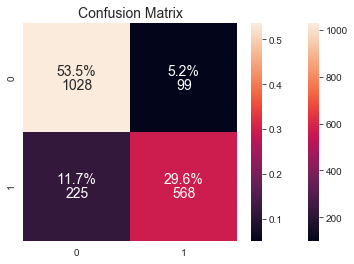

In [125]:
# stacking a new model (LR) on top of the two bases
df_stack_tr = pd.concat([train_pred1, train_pred2], axis=1)
df_stack_tr.columns = ['xgb','svc']
df_stack_tst = pd.concat([test_pred1, test_pred2], axis=1)
df_stack_tst.columns = ['xgb','svc']

model_stack = LogisticRegression(solver='lbfgs', random_state=42)
model_stack.fit(df_stack_tr, y_train.koi_pdisposition)

print('Train Score:', model_stack.score(df_stack_tr, y_train.koi_pdisposition))
print('Test Score:', model_stack.score(df_stack_tst, y_test.koi_pdisposition))
y_pred = model_stack.predict(df_stack_tst)
confu_matrix(y_pred, df_stack_tst, y_test)

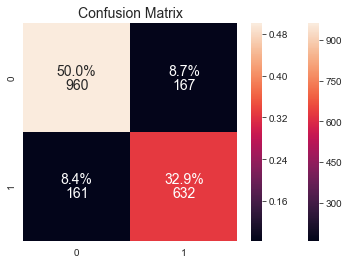

Train accuracy: 80.56%
Test accuracy: 82.92%
{'C': [1.5], 'class_weight': ['balanced'], 'solver': ['newton-cg']}


In [126]:
# tuning stacked model hyperparameters
for i in [1]:
    if i == 1:
        X_train = df_stack_tr
        X_test = df_stack_tst
        model_stack = LogisticRegression(random_state=42)
        lr_params = {'C': [.1, 1, 1.5, 2, 2.5],
                     'class_weight': [None,'balanced'],
                     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                    }
        best_params, model_stacked = gridsearch_params(model_stack, lr_params, update_params=False)

## Sigh...

Oddly, the model performs better on the test dataset than it does on the train dataset. At least the scores are pretty close together.

# Results and Interpretation

So, after all of this nonsense, it appears that the two models which struck the best balance between test accuracy score and minimizing overfitting were the vanilla versions of SVC. Here's a table comparing them all (in descending order of Test Accuracy):

| Order created in notebook | Method | PCA? | Train | Test | divergence |
| --- | --- | --- | --- | --- | --- |
| 13 | SVC (vanilla) | yes | 85.60% | 83.59% | 2.01% |
| 6 | SVC grid | no | 84.59% | 83.33% | 1.26% |
| 14 | SVC grid | yes | 84.94% | 83.23% | 1.71% |
| 7 | RFC (vanilla) | no | 99.98% | 83.18% | 16.80% |
| 15 | STACK (XGB-SVC ---> LR) | yes | 80.30% | 83.12% | 2.82% |
| 5 | SVC (vanilla) | no | 85.24% | 82.92% | 2.32% |
| 16 | STACK grid (XGB-SVC ---> LR) | yes | 80.56% | 82.92% | 2.36% |
| 1 | XGB (vanilla): | no | 85.24% | 82.03% | 3.21% |
| 3 | " XGB grid (depth--child): " | no | 84.00% | 81.98% | 2.02% |
| 4 | " XGB grid (+gam—subs--col): " | no | 83.57% | 81.98% | 1.59% |
| 10 | XGB (vanilla): | yes | 86.57% | 81.93% | 4.64% |
| 12 | " XGB grid (+gam—subs--col): " | yes | 86.68% | 81.88% | 4.80% |
| 11 | " XGB grid (depth--child): " | yes | 86.82% | 81.72% | 5.10% |
| 8 | RFC grid | no | 81.38% | 80.52% | 0.86% |
| 2 | XGB-SVC-RFC (vanilla): | no | 96.76% | 80.26% | 16.50% |
| 9 | XGBgrid+SVCgrid+RFCgrid: | no | 83.46% | 80.05% | 3.41% |

What's the takeaway from all of this? Don't put any effort into building a model   **`:-P`**

But seriously, apparently XGBoost and Support Vector Classifiers are already pretty powerful, so there's not much room for improvement, at least with this dataset.

At best, we can correctly identify whether a Kepler Object of Interest is a planet or not with only 82% or 83% accuracy.